# Weather Time Series Forecasting with Attention and Transformers

In this notebook, we explore modern sequence modeling techniques for weather time series forecasting. We experiment with both custom and modular implementations of attention-based neural networks and Transformer-encoder architectures to better understand their behavior and performance.

## Get the Dataset ready

In [ ]:
# useful imports
import os
import time
import json, zipfile
import numpy as np
import pandas as pd
import math
from google.colab import files
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# upload files with sequences
uploaded = files.upload()

Saving dataloaders_meta_v1.zip to dataloaders_meta_v1 (1).zip


In [ ]:
# unzip and load files
with zipfile.ZipFile("dataloaders_meta_v1.zip", "r") as zip_ref:
  zip_ref.extractall(".")

series_data = np.load("series_loaders_norm_v1.npz")
with open("series_meta_v1.json") as f:
  series_meta = json.load(f)

# print their contents
print(series_data.files)  # list
print(series_meta)  # dict of dicts

['X_h_train', 'y_h_train', 'X_h_val', 'y_h_val', 'X_h_test', 'y_h_test', 'X_h6_test', 'y_h6_test', 'X_6_train', 'y_6_train', 'X_6_val', 'y_6_val', 'X_6_test', 'y_6_test', 'X_64_test', 'y_64_test', 'X_24_train', 'y_24_train', 'X_24_val', 'y_24_val', 'X_24_test', 'y_24_test']
{'hour': {'window_size': 48, 'mean': 12.059760961214163, 'std': 7.440424738826732}, 'six': {'window_size': 56, 'mean': 12.063966322683916, 'std': 7.252902404402592}, 'day': {'window_size': 28, 'mean': 12.06806762756527, 'std': 6.560335379023}}


In [ ]:
def to_loader(X, y, batch_size=32):
  X = torch.from_numpy(X).float()
  y = torch.from_numpy(y).float()
  if y.ndim == 1:  # ensure (N,1) for later ops
    y = y.reshape(-1, 1)
  return DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=False, drop_last=False)

# rebuild loaders (same names as previous notebook)
hour_train_loader = to_loader(series_data["X_h_train"], series_data["y_h_train"])
hour_val_loader = to_loader(series_data["X_h_val"], series_data["y_h_val"])
hour_test_loader = to_loader(series_data["X_h_test"], series_data["y_h_test"])
hour6_test_loader = to_loader(series_data["X_h6_test"], series_data["y_h6_test"])

six_train_loader = to_loader(series_data["X_6_train"], series_data["y_6_train"])
six_val_loader = to_loader(series_data["X_6_val"], series_data["y_6_val"])
six_test_loader = to_loader(series_data["X_6_test"], series_data["y_6_test"])
six4_test_loader = to_loader(series_data["X_64_test"], series_data["y_64_test"])

day_train_loader = to_loader(series_data["X_24_train"], series_data["y_24_train"])
day_val_loader = to_loader(series_data["X_24_val"], series_data["y_24_val"])
day_test_loader = to_loader(series_data["X_24_test"], series_data["y_24_test"])

print("All loaders rebuilt.")

All loaders rebuilt.


In [ ]:
# unpack meta data
flat_meta = {}

for name, meta in series_meta.items():
  for k, v in meta.items():
    flat_meta[f"{name}_{k}"] = v

hour_window_size = flat_meta["hour_window_size"]
hour_mean = flat_meta["hour_mean"]
hour_std = flat_meta["hour_std"]

six_window_size = flat_meta["six_window_size"]
six_mean = flat_meta["six_mean"]
six_std = flat_meta["six_std"]

day_window_size = flat_meta["day_window_size"]
day_mean = flat_meta["day_mean"]
day_std = flat_meta["day_std"]

# for k, v in flat_meta.items():
#   print(f"{k}: {v}")

print("All meta data unpacked.")

All meta data unpacked.


## Attention Mechanism

### Introduction to Self-Attention

In [ ]:
# some info of the DataLoader
print("DataLoader (hour_train_loader): ", hour_train_loader)
print("Type:", type(hour_train_loader))
print("Dataset type:", type(hour_train_loader.dataset))
print("Number of batches:", len(hour_train_loader))
print("Batch size:", hour_train_loader.batch_size)

print("Dataset length (total samples):", len(hour_train_loader.dataset))
print("Computed (num_batches * batch_size):", len(hour_train_loader) * hour_train_loader.batch_size)

print("\nOne batch consists of X, y:")
batch = next(iter(hour_train_loader))
# print("Batch type:", type(batch))
X, y = batch
print("X dtype:", X.dtype, "y dtype:", y.dtype)
print("X shape:", X.shape, "y shape:", y.shape)

# show a single element (first sample)
x = X[0]
y = y[0]
# print("\nFirst sample and its label:\n", x, y)
print("\nFirst sample's features (X) and label (y) shapes:", x.shape, y.shape)

DataLoader (hour_train_loader):  <torch.utils.data.dataloader.DataLoader object at 0x788be1da2600>
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Dataset type: <class 'torch.utils.data.dataset.TensorDataset'>
Number of batches: 221
Batch size: 32
Dataset length (total samples): 7068
Computed (num_batches * batch_size): 7072

One batch consists of X, y:
X dtype: torch.float32 y dtype: torch.float32
X shape: torch.Size([32, 48, 1]) y shape: torch.Size([32, 1])

First sample's features (X) and label (y) shapes: torch.Size([48, 1]) torch.Size([1])


In [ ]:
# grab one batch from loader
batch = next(iter(hour_train_loader))
X, y = batch

# take first sequence and target
x = X[0]   # shape: (seq_len, input_size) or (seq_len,)
y = y[0]

print("Original x shape:", x.shape)
print("Original y shape:", y.shape if hasattr(y, "shape") else type(y))

# ensure x has shape (seq_len, batch, input_size)
if x.ndim == 1:
    x = x.unsqueeze(-1)   # (seq_len, 1)
x = x.unsqueeze(1)        # (seq_len, batch=1, input_size=1)
print("x reshaped for RNN:", x.shape)

# define a simple RNN
input_size = x.shape[-1]   # here 1 (temperature)
hidden_size = 4            # arbitrary hidden dimension
rnn = nn.RNN(input_size, hidden_size, batch_first=False)

# forward pass
output, hidden = rnn(x)

print("\n--- RNN outputs ---")
print("output (all hidden states):", output.shape,
      " -> sequence of context vectors (one per timestep)")
print("hidden (last hidden state):", hidden.shape,
      " -> final context vector summarizing the sequence")
print("\nExample:")
print("At time t, output[t] is the hidden state after t steps:", output[0].shape)
print("Final hidden state (same as last output row):", hidden[-1].shape)

Original x shape: torch.Size([48, 1])
Original y shape: torch.Size([1])
x reshaped for RNN: torch.Size([48, 1, 1])

--- RNN outputs ---
output (all hidden states): torch.Size([48, 1, 4])  -> sequence of context vectors (one per timestep)
hidden (last hidden state): torch.Size([1, 1, 4])  -> final context vector summarizing the sequence

Example:
At time t, output[t] is the hidden state after t steps: torch.Size([1, 4])
Final hidden state (same as last output row): torch.Size([1, 4])


We simulate self attention for just one sample and then we generalize for the entire dataset.

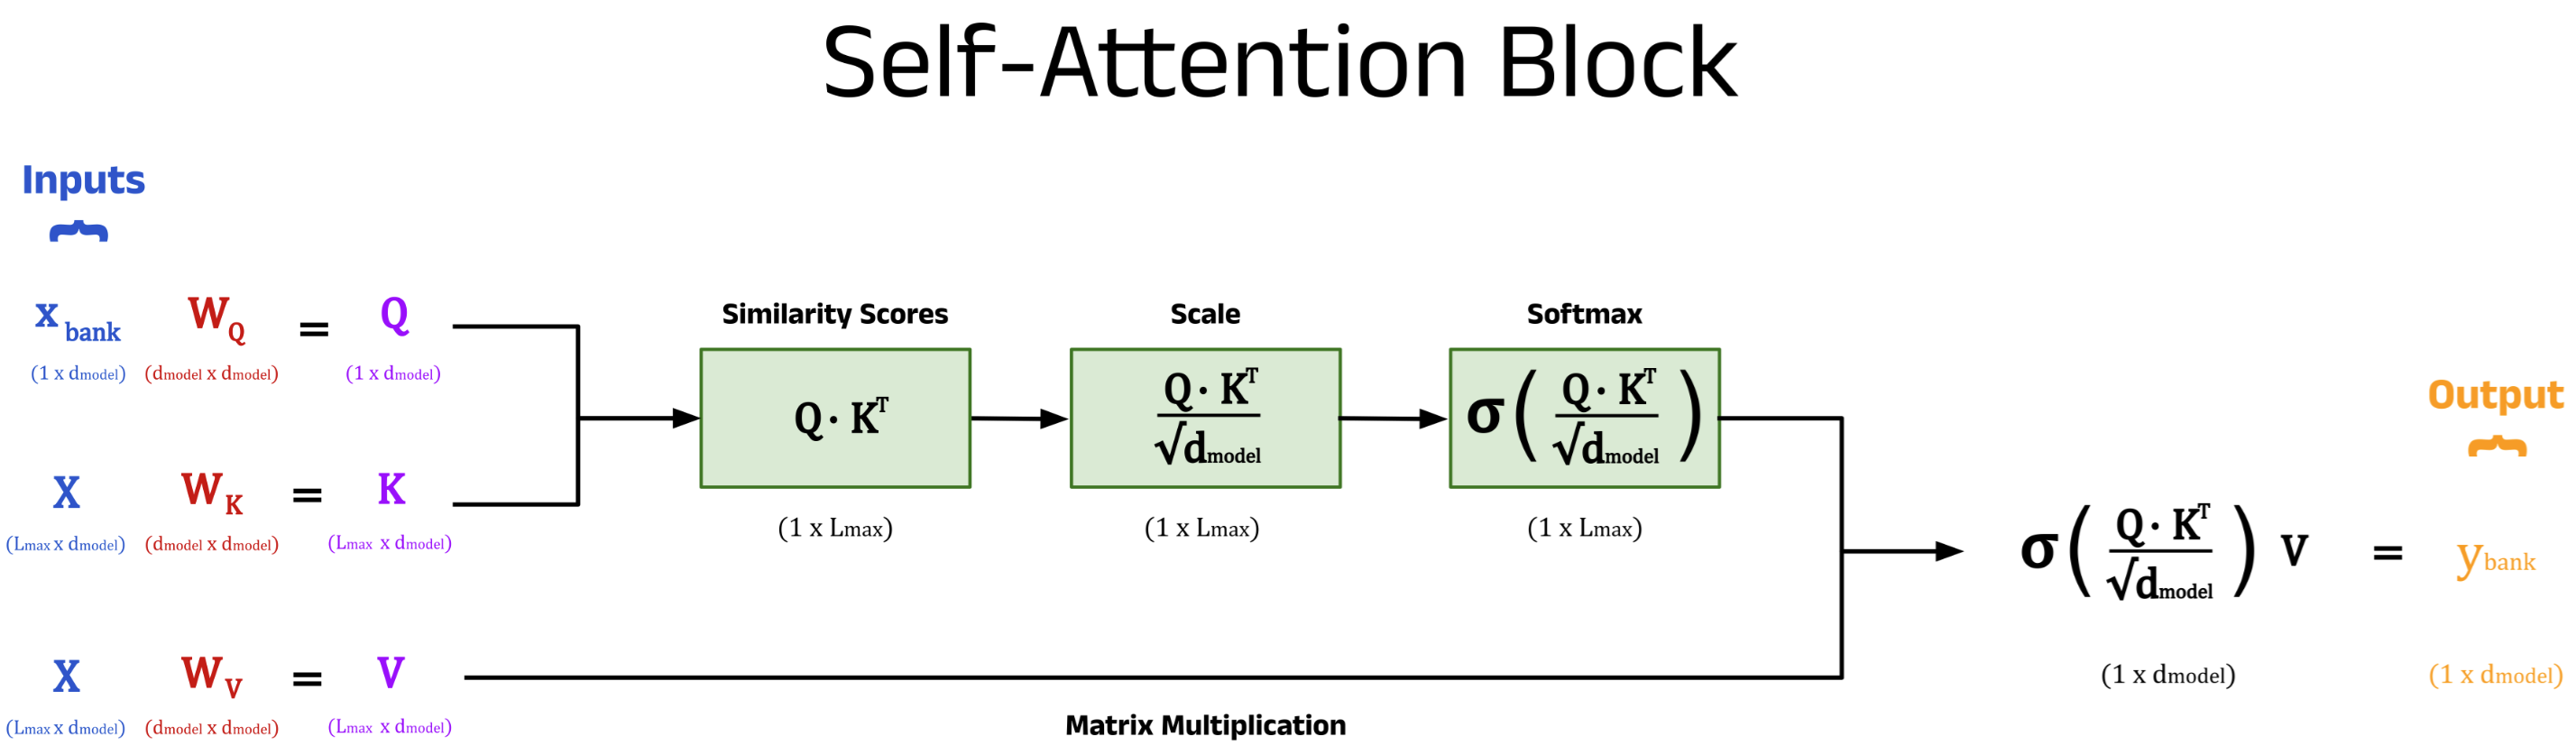

Here, we show a simple self-attention example. In practice, a preliminary embedding step is usually applied to map each input vector into a higher-dimensional space, and we include it here for completeness even though it is not explicitly shown in the core attention equations.

We will also keep this embedding step in both the custom and modular versions of the attention-based networks below, to ensure a fair comparison with the Transformer models (same dimensional projections).

In [ ]:
# we'll embed this input (48, 1) into a higher-dimensional space, for example 8D, so its shape becomes (48, 8) - one 8D per time step
d_model = 8

# initialize random projection matrices for Q, K, V, each has shape (1, d_model) -> projecting 1D input to 8D space
W_q = torch.randn(1, d_model)
W_k = torch.randn(1, d_model)
W_v = torch.randn(1, d_model)

# check W_q
print("W_q:", W_q)
print("W_q shape:", W_q.shape)

W_q: tensor([[-1.3078, -0.1847,  0.2505,  0.8234, -0.7523,  0.9093, -0.4339, -1.6237]])
W_q shape: torch.Size([1, 8])


In [ ]:
# compute Q, K, V matrices by linear projection
# this is essentially learning how each timestep in x is similar to every other timestep in x (here how similar is first sample with itself!)
# the self-attention mechanism computes dependencies within a single sequence (sample), not across samples. Each timestep becomes a query, key, and value vector!
x = x.squeeze(-1) # drop the batch size
Q = x @ W_q  # shape: (48, d_model)
K = x @ W_k  # shape: (48, d_model)
V = x @ W_v  # shape: (48, d_model)

# print shapes to verify
# print("Q:", Q)
print("Q shape:", Q.shape)
print("K shape:", K.shape)
print("V shape:", V.shape)

Q shape: torch.Size([48, 8])
K shape: torch.Size([48, 8])
V shape: torch.Size([48, 8])


In [ ]:
# step 1: compute raw attention scores (similarities) between all timesteps
# scores[i][j] represents similarity between timestep i and timestep j
scores = Q @ K.T  # shape: (48, 48)
print("Attention scores shape:", scores.shape)
print("First attention score:", scores[0])

# step 2: scale the scores
scaled_scores = scores / torch.sqrt(torch.tensor(d_model, dtype=torch.float32))
print("\nFirst attention score after scaling:", scaled_scores[0])

# step 3: apply softmax to get attention weights
attn_weights = F.softmax(scaled_scores, dim=1)  # shape: (48, 48)
print("\nAttention weights shape:", attn_weights.shape)
print("First attention weights:", attn_weights[0])

# step 4: compute weighted sum of values using the attention weights
# this gives the attended representation for each timestep
attn_output = attn_weights @ V  # shape: (48, d_model)
print("\nAttention output shape:", attn_output.shape)
print("First attention output:", attn_output[0])

Attention scores shape: torch.Size([48, 48])
First attention score: tensor([ -7.1989,  -7.4725,  -7.6574,  -7.9469,  -8.4495,  -8.9427,  -9.2332,
         -9.1601,  -9.4015,  -9.3983,  -8.4286,  -7.9281,  -6.6062,  -5.4170,
         -5.1714,  -4.8308,  -5.6573,  -6.7410,  -7.5487,  -8.4098,  -8.8654,
         -9.4265,  -9.6324,  -9.5697,  -9.9072, -10.2918, -10.3242, -10.6554,
        -10.6544, -10.8467, -11.0515, -10.7265, -10.7986, -10.2803,  -9.5645,
         -7.8758,  -5.9583,  -3.8736,  -3.9216,  -4.1170,  -5.3856,  -6.2498,
         -7.0001,  -7.7901,  -7.8591,  -7.6783,  -7.3815,  -7.1736])

First attention score after scaling: tensor([-2.5452, -2.6419, -2.7073, -2.8096, -2.9873, -3.1617, -3.2644, -3.2386,
        -3.3239, -3.3228, -2.9800, -2.8030, -2.3356, -1.9152, -1.8284, -1.7079,
        -2.0002, -2.3833, -2.6689, -2.9733, -3.1344, -3.3328, -3.4056, -3.3834,
        -3.5027, -3.6387, -3.6501, -3.7673, -3.7669, -3.8349, -3.9073, -3.7924,
        -3.8179, -3.6346, -3.3816, -2

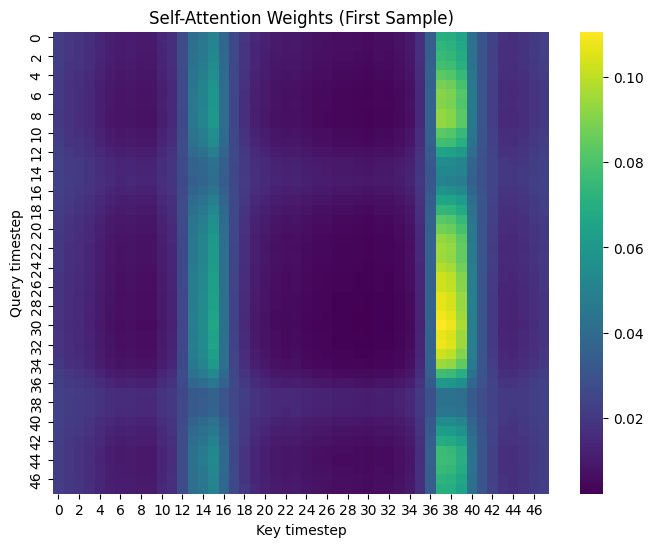

In [ ]:
# visualize the attention weights as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(attn_weights.detach().numpy(), cmap='viridis')
plt.title("Self-Attention Weights (First Sample)")
plt.xlabel("Key timestep")
plt.ylabel("Query timestep")
plt.show()

**Notes:**  

- The projection weights `W_q` and `W_k` are randomly initialized, so initial attention scores are not uniform even when x is compared with itself.  
- After training, these weights learn to focus attention on the most relevant timesteps.  
- We transformed the input from shape $(48,)$ to $(48, 8)$, each timestep now has an 8-dimensional representation that blends information from all others.  
- Next, we feed this updated representation into a simple linear layer to make the final prediction.

In [ ]:
# flatten the attention output: from (48, 8) to (384,)
attn_output_flat = attn_output.flatten()
print("Flattened attention output shape:", attn_output_flat.shape)
print("First flattened attention output:", attn_output_flat[0]) # scalar
print("First flattened attention output:", attn_output_flat[0].shape)

Flattened attention output shape: torch.Size([384])
First flattened attention output: tensor(1.0682)
First flattened attention output: torch.Size([])


In [ ]:
# define a simple feedforward layer to map from 384 → 1 (scalar prediction)
fc = nn.Linear(48 * d_model, 1)

# predict the next value (25th timestep)
prediction = fc(attn_output_flat)  # shape: (1,)
print("Predicted (unormalized) value:", prediction.item())  #  (scalar)

Predicted (unormalized) value: 0.105607770383358


### Custom Self-Attention

In [ ]:
# helper function

def r2_fn(y_trues, y_preds):
  """
  Calculates the R² score for regression ("How well is the model explaining the variance of the target?").

  Args:
    - y_trues: list or tensor of true target values (e.g. actual temperatures)
    - y_preds: list or tensor of predicted values from the model

  Returns:
    - R² score: a float in (-∞, 1], where 1.0 is perfect prediction

  Definition:
    R² measures how well the predicted values approximate the actual values.

    R² = 1 - (SS_residual / SS_total), where:

      SS_residual = Σ(yᵢ - ŷᵢ)²  → the sum of squared errors (model residuals)
      SS_total    = Σ(yᵢ - ȳ)²   → the total variance in the data (relative to mean)

  Interpretation:
    - R² = 1 → perfect prediction
    - R² = 0 → model does no better than mean
    - R² < 0 → model is worse than just predicting the mean
  """
  if not isinstance(y_trues, torch.Tensor):
    y_trues = torch.tensor(y_trues, dtype=torch.float32)
  if not isinstance(y_preds, torch.Tensor):
    y_preds = torch.tensor(y_preds, dtype=torch.float32)

  # flatten tensors to work for (N,), (N,1), multi-horizon (N,H)
  y_trues = y_trues.reshape(-1)
  y_preds = y_preds.reshape(-1)

  ss_total = torch.sum((y_trues - y_trues.mean()) ** 2)
  ss_residual = torch.sum((y_trues - y_preds) ** 2)

  r2 = 1.0 - ss_residual / (ss_total - 1e-8) # results a tensor
  return float(r2)  # return a float number


def plot_history(history):
  """
  Plots train/val Loss and R².

  Args:
    - history: dictionary with keys 'train_loss', 'val_loss', 'train_r2', 'val_r2'
  """
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  fig.suptitle('Training & Validation Curves', fontsize=14)

  # loss
  ax1.plot(history['train_loss'], label='Train Loss')
  ax1.plot(history['val_loss'],   label='Val Loss')
  ax1.set_title('Loss Curves')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  ax1.grid(True)

  # R²
  ax2.plot(history['train_r2'], label='Train')
  ax2.plot(history['val_r2'],   label='Val')
  ax2.set_title('R² Curves')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('R²')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()
  plt.show()


def plot_residuals_preds(y_true, y_pred, index=None, feature_name="T", date_fmt="%Y-%m-%d %H:%M", h=None):
  """
  Side-by-side plots: residuals (y_true - y_pred) and Test vs Predictions.

  Args:
      y_true (np.ndarray | pd.Series): Ground truth. Shape (N,) for one-step pred or (N,H) for multi-step pred
      y_pred (np.ndarray | pd.Series): Predictions. Shape (N,) for one-step pred or (N,H) for multi-step pred
      index (pd.Index | None): Optional x-axis index for plotting (e.g. DateTimeIndex)
      feature_name (str): Y-axis label for Test vs Predictions
      date_fmt (str): Datetime tick format if index is datetime-like
      h (int | None): For 1-step is None, for multi-step is (h-1) as is 0-based
  """
  # to numpy
  yt = y_true.values if isinstance(y_true, pd.Series) else np.asarray(y_true)
  yp = y_pred.values if isinstance(y_pred, pd.Series) else np.asarray(y_pred)

  # - Else -> flatten all horizons to one long vector and drop datetime index.
  if yt.ndim == 2 and yp.ndim == 2:
    if h is not None:
      yt, yp = yt[:, h], yp[:, h] # 1-step case: pick the one horizon
    else:
      yt, yp = yt.reshape(-1), yp.reshape(-1) # multi-step case: flatten all horizons
      index = None # no dates when flattened

  # align lengths
  n = min(len(yt), len(yp))
  yt, yp = yt[:n], yp[:n]

  # x-axis: use given pandas index if valid/long enough
  use_idx = isinstance(index, pd.Index) and len(index) >= n
  x = (index[:n] if use_idx else np.arange(n))

  # residuals
  res = yt - yp

  # plots
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  axes[0].plot(x, res, label="Residuals")
  axes[0].axhline(0, ls="--", color="r", lw=1)
  axes[0].set_title("Residuals")
  axes[0].set_xlabel("Time")
  axes[0].set_ylabel("Error")
  axes[0].legend()

  axes[1].plot(x, yt, label="Test")
  axes[1].plot(x, yp, label="Pred")
  axes[1].set_title("Test vs Predictions")
  axes[1].set_xlabel("Time")
  axes[1].set_ylabel(feature_name)
  axes[1].legend()

  # datetime formatting
  if use_idx and pd.api.types.is_datetime64_any_dtype(index):
    for ax in axes:
      ax.xaxis.set_major_locator(mdates.AutoDateLocator())
      ax.xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
      for lbl in ax.get_xticklabels():
        lbl.set_rotation(45); lbl.set_ha("right")

  plt.tight_layout()
  plt.show()


def count_trainable_params(params):
  """
  Counts the total number of trainable params. This will be used for capacity comparisons between simple and more complex deep neural networks.

  Args:
    - params: list of torch.nn.Parameter objects

  Returns:
    - total number of trainable params
  """
  return sum(p.numel() for p in params if p.requires_grad)


def evaluate_model(y_true, y_pred):
  """
  Computes MAE, RMSE, and MAPE (%) and return them as formatted strings.

  Args:
      y_true (array-like): Ground truth values
      y_pred (array-like): Model predictions
  """
  # ensure y_true and y_pred are of the same lengths
  if len(y_true) != len(y_pred):
    raise ValueError("Input arrays must have the same length.")

  # MAE: mean absolute error
  mae = np.mean(np.abs(y_true - y_pred))

  # RMSE: root mean squared error
  rmse = np.sqrt(np.mean((y_true - y_pred)**2))

  # MAPE: mean absolute percentage error
  denom = np.clip(np.abs(y_true), 1e-8, None)  # if 0 -> use 1e-8 (avoid division by zero)
  mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100

  return (f"{mae:.2f}", f"{rmse:.2f}", f"{mape:.2f}")


def plot_learning_curves_all(histories, resolution_labels):
  """
  Plots train/val loss and accuracy curves for multiple time resolutions.

  Args:
      histories (list of dict): Each dict must contain keys: 'train_loss', 'val_loss', 'train_r2', 'val_r2'
      resolution_labels (list of str): Labels like ["1H", "6H", "24H"]
  """
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex=True)
  fig.suptitle("Training & Validation Curves per Time Resolution", fontsize=14)

  for i, (history, label) in enumerate(zip(histories, resolution_labels)):
    # plot loss
    axes[i, 0].plot(history['train_loss'], label='Train Loss')
    axes[i, 0].plot(history['val_loss'], label='Val Loss')
    axes[i, 0].set_ylabel(f'{label} Loss')
    axes[i, 0].set_title(f'{label} Time Resolution')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # plot accuracy
    axes[i, 1].plot(history['train_r2'], label='Train R²')
    axes[i, 1].plot(history['val_r2'], label='Val R²')
    axes[i, 1].set_ylabel(f'{label} R²')
    axes[i, 1].set_title(f'{label} Time Resolution')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

  axes[2, 0].set_xlabel("Epoch")
  axes[2, 1].set_xlabel("Epoch")
  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()


def denormalize(x_norm, mu, std):
  """
  Inverse of normalize_series.

  Args:
      x_norm (pd.Series or np.ndarray): Normalized time series.
      mu (float): Mean of the original series.
      std (float): Std of the original series.

  Returns:
      pd.Series: Denormalized series.
  """
  return x_norm * std + 1e-12 if std == 0 else x_norm * std + mu

In [ ]:
# custom attention-based NN
def custom_self_attention(x, W_q, W_k, W_v, d_model):
  """
  Applies the Self-Attention mechanism.

  Args:
    - x: (seq_len, input_size) input sequence
    - W_q: (input_size, d_model) projection matrix for queries
    - W_k: (input_size, d_model) projection matrix for keys
    - W_v: (input_size, d_model) projection matrix for values
    - d_model: dimension of attention projection

  Returns:
    - output: (seq_len, d_model) attended sequence
    - attn_weights: (seq_len, seq_len) attention weights
  """
  # ensure 2D (seq_len, input_size), input_size = in_features (in case of multivariate features)
  in_features = W_q.shape[0]
  if x.ndim != 2:
    x = x.reshape(-1, in_features)

  # compute Q, K and V matrices
  Q = x @ W_q  # (seq_len, d_model)
  K = x @ W_k
  V = x @ W_v
  # print("Q:", Q.shape, "| K:", K.shape, "| V:", V.shape)

  # self-attention
  scores = (Q @ K.transpose(0, 1)) / math.sqrt(d_model)  # (seq_len, seq_len)
  attn_weights = F.softmax(scores, dim=-1)  # (seq_len, seq_len)
  output = attn_weights @ V  # (seq_len, d_model)
  # print("Attention output:", output.shape, "| Attention weights:", attn_weights.shape)
  return output, attn_weights


def train_custom_attention(train_loader, val_loader, model_dim, input_size=1, output_size=1, epochs=100, lr=1e-3, weight_decay=1e-4, patience=10, verbose_every=10):
  """
  Trains a custom self-attention model on univariate time using DataLoaders.

  Args:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - model_dim: int, dimension of attention projection
    - input_size: int, input features per time step (1 is for univariate case)
    - output_size: int, output features per time step (1 is for univariate case)
    - epochs: int, number of training epochs
    - lr: float, learning rate
    - weight_decay: float, L2 regularization strength
    - patience: int, early stopping patience
    - verbose_every: int, print progress every n epochs

  Returns:
    - history dictionary with several metrics (e.g. train_loss, val_loss, train_r2, val_r2)
  """
  # use gpu, if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # initialize weights with xavier
  W_q = nn.Parameter(torch.empty(input_size, model_dim, device=device))
  W_k = nn.Parameter(torch.empty(input_size, model_dim, device=device))
  W_v = nn.Parameter(torch.empty(input_size, model_dim, device=device))

  nn.init.xavier_uniform_(W_q)
  nn.init.xavier_uniform_(W_k)
  nn.init.xavier_uniform_(W_v)

  # infer sequence length from one batch
  with torch.no_grad():
    xb0, _ = next(iter(train_loader))
    seq_len = xb0.shape[1]

  # linear layer
  # fc = nn.Linear(seq_len * model_dim, output_size, device=device)
  # params = [W_q, W_k, W_v] + list(fc.parameters())

  fc_W = nn.Parameter(torch.empty(seq_len * model_dim, output_size, device=device))
  nn.init.xavier_uniform_(fc_W)
  fc_b = nn.Parameter(torch.zeros(output_size, device=device))
  params = [W_q, W_k, W_v, fc_W, fc_b]

  # set optimizer and loss
  optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
  loss_fn = nn.MSELoss()

  # history and early stopping
  history = {'train_loss': [], 'val_loss': [], 'train_r2': [], 'val_r2': [] }
  best_val_loss = float("inf")
  best_state = [p.detach().clone() for p in params]  # init
  no_improve = 0
  stopped_epoch = 0

  # train step
  start_time = time.time()
  for epoch in range(epochs):
    total_loss = 0.0
    train_preds, train_targets = [], []

    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      batch_len = X_batch.shape[0]
      sample_losses = []

      for i in range(batch_len):
        x_seq = X_batch[i]  # (seq_len,) e.g. (48,)
        y_t = y_batch[i]  # scalar

        x_seq = x_seq.reshape(-1, input_size)  # (seq_len, input_size), e.g. (48,) → (48, 1)

        # print(x_seq.shape, W_q.shape, W_k.shape, W_v.shape, model_dim)
        att_out, _ = custom_self_attention(x_seq, W_q, W_k, W_v, model_dim)  # (24, model_dim)
        flat_att_out = att_out.flatten()  # (48 * model_dim,)
        # print("Flattened attention output shape:", flat_att_out.shape)
        # y_pred = fc(flat_att_out).squeeze() # scalar
        y_pred = (flat_att_out @ fc_W).squeeze() + fc_b  # cutom linear, returns (1,)

        loss = loss_fn(y_pred, y_t)
        sample_losses.append(loss)

        train_preds.append(y_pred.item())
        train_targets.append(float(y_t))

      # batch-mean backward instead of per-sample backward
      batch_loss = torch.stack(sample_losses).mean()
      optimizer.zero_grad()
      batch_loss.backward()
      torch.nn.utils.clip_grad_norm_(params, max_norm=5.0)
      optimizer.step()

      total_loss += batch_loss.item()

    avg_train_loss = total_loss / max(1, len(train_loader))
    train_r2 = r2_fn(train_targets, train_preds)

    # validation step
    val_total_loss = 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
      for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_len = X_batch.shape[0]
        sample_val_losses = []

        for i in range(batch_len):
          x_seq = X_batch[i]
          y_t = y_batch[i]

          x_seq = x_seq.reshape(-1, input_size)  # ensures (seq_len, input_size)

          att_out, _ = custom_self_attention(x_seq, W_q, W_k, W_v, model_dim)
          flat_att_out = att_out.flatten()
          y_pred = (flat_att_out @ fc_W).squeeze() + fc_b

          loss = loss_fn(y_pred, y_t)
          sample_val_losses.append(loss)

          val_preds.append(float(y_pred))
          val_targets.append(float(y_t))

        val_total_loss += torch.stack(sample_val_losses).mean().item()

    avg_val_loss = val_total_loss / max(1, len(val_loader))
    val_r2 = r2_fn(val_targets, val_preds)

    # store metrics
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_r2'].append(train_r2)
    history['val_r2'].append(val_r2)

    if (epoch + 1) % verbose_every == 0:
      print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, R²: {train_r2:.4f} | Val Loss: {avg_val_loss:.4f}, R²: {val_r2:.4f}")

    # early stopping
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_state = [p.detach().clone() for p in params]
      no_improve = 0
    else:
      no_improve += 1
      if no_improve >= patience:
        stopped_epoch = epoch + 1
        print(f"Early stopping at epoch {stopped_epoch} "
              f"(best val loss: {best_val_loss:.6f})")
        break

  total_time = time.time() - start_time
  print(f"\nTotal training time: {total_time:.2f} seconds")

  total_params = count_trainable_params(params)
  print(f"Total trainable parameters: {total_params}\n")

  # restore best weights & finalize history ----
  for p, bp in zip(params, best_state):
    p.data.copy_(bp)
  best_params = [p.detach().clone() for p in params]

  if stopped_epoch == 0:
    stopped_epoch = epoch + 1

  history.update({
        'params': best_params,
        'total_training_time': round(total_time, 4),
        'total_params': total_params,
        'best_val_loss': float(best_val_loss),
        'stopped_epoch': stopped_epoch
    })

  return history


def predict_custom_attention(data_loader, params, n_steps=1):
  """
  Makes 1-step or n-step ahead predictions with the manual Attention model.

  Args:
    - data_loader: yields (Xb, yb), where Xb has shape (B, seq_len, 1) or (B, seq_len) and yb is either (B,) for 1-step or (B, n_steps) for multi-step loaders
    - params: list [W_q, W_k, W_v, fc_W, fc_b] from trained attention model
    - n_steps: int, number of steps ahead to predict (default: 1)

  Returns:
      - preds_last: (N,) last-step predictions (t + n_steps)
      - trues_last: (N,) last-step ground truths
      - preds_rollout:(N, n_steps) full recursive rollout [t+1 ... t+n_steps]
      - trues_rollout:(N, n_steps) matching ground truths
  """
  W_q, W_k, W_v, fc_weights, fc_bias = params
  # print(W_q.shape, W_k.shape, W_v.shape, fc_weight.shape, fc_bias.shape)
  device = W_q.device
  in_features = W_q.shape[0] # input_size
  d_model = W_q.shape[1] # model_dim

  # collectors
  preds_last, trues_last = [], []
  preds_rollout, trues_rollout = [], []

  for Xb, yb in data_loader:
    Xb = Xb.to(device)
    yb = yb.to(device)
    B = Xb.shape[0]

    for i in range(B):
      input_seq = Xb[i]  # (seq_len, 1)
      input_seq = input_seq.reshape(-1, in_features) # (seq_len, in_features)

      # gather truths
      y_true_vec = yb[i].view(-1) # (n_steps,) or (1,)

      # roll out n steps autoregressively
      step_preds = []
      seq_len = input_seq.shape[0]

      for _ in range(n_steps):
        # step 1: compute attention representation of input sequence

        # Q/K/V (seq_len, d_model)
        Q = input_seq @ W_q
        K = input_seq @ W_k
        V = input_seq @ W_v

        model_dim = Q.shape[1]
        scores = (Q @ K.transpose(0, 1)) / math.sqrt(model_dim)
        attn_weights = torch.softmax(scores, dim=-1)
        attn_out = attn_weights @ V  # (seq_len, model_dim)

        # step2: flatten and predict next value
        flat_attn = attn_out.flatten() # (seq_len * d_model,)
        y_pred = (flat_attn @ fc_weights).squeeze() + fc_bias  # (1, output_size), e.g. (1, 1)
        y_val = float(y_pred.item()) # scalar
        step_preds.append(y_val) # append preds to results

        # step 3: update input sequence for next prediction (autoregressive: shift window with predicted value)
        next_input = torch.tensor([[y_val]], dtype=input_seq.dtype, device=device)  # (1, 1)
        # print(next_input.shape)
        input_seq = torch.cat([input_seq[1:], next_input], dim=0)  # roll window by one (seq_len,1)

      # store predictions
      preds_rollout.append(step_preds)
      preds_last.append(step_preds[-1])

      # store truths
      y_i = yb[i].view(-1)  # works for (1,) or (n_steps,)
      if n_steps == 1 and y_true_vec.numel() == 1:
        trues_rollout.append([float(y_true_vec.item())])
        trues_last.append(float(y_true_vec.item()))
      elif n_steps > 1:
        yi = y_true_vec[:n_steps].detach().cpu().numpy().astype(float)
        trues_rollout.append(yi.tolist())
        trues_last.append(float(yi[-1]))
      else:
        raise ValueError(f"Ground-truth horizon mismatch: got {y_true_vec.numel()} labels but n_steps={n_steps}.")

  # to numpy
  preds_last_np = np.asarray(preds_last, dtype=float)
  trues_last_np = np.asarray(trues_last, dtype=float)
  preds_rollout_np = np.asarray(preds_rollout, dtype=float)
  trues_rollout_np = np.asarray(trues_rollout, dtype=float)

  return preds_last_np, trues_last_np, preds_rollout_np, trues_rollout_np

In [ ]:
# train NNs with attention
print("Training NN with custom attention for 1H resolution")
history1h_custom_att = train_custom_attention(hour_train_loader, hour_val_loader, input_size=1, model_dim=16)

print("Training NN with custom attention for 6H resolution")
history6h_custom_att = train_custom_attention(six_train_loader, six_val_loader, input_size=1, model_dim=16)

print("Training NN with custom attention for 1D resolution")
history24h_custom_att = train_custom_attention(day_train_loader, day_val_loader, input_size=1, model_dim=16)

Training NN with custom attention for 1H resolution
Epoch 10/100, Train Loss: 0.1252, R²: 0.8729 | Val Loss: 0.4147, R²: 0.5796
Early stopping at epoch 11 (best val loss: 0.402178)

Total training time: 68.70 seconds
Total trainable parameters: 817

Training NN with custom attention for 6H resolution
Epoch 10/100, Train Loss: 0.4078, R²: 0.5888 | Val Loss: 0.9972, R²: -0.2292
Epoch 20/100, Train Loss: 0.2209, R²: 0.7794 | Val Loss: 0.6440, R²: 0.1507
Early stopping at epoch 27 (best val loss: 0.565615)

Total training time: 26.24 seconds
Total trainable parameters: 945

Training NN with custom attention for 1D resolution
Epoch 10/100, Train Loss: 0.2945, R²: 0.6724 | Val Loss: 1.2883, R²: -5.3504
Early stopping at epoch 14 (best val loss: 1.282426)

Total training time: 3.22 seconds
Total trainable parameters: 497



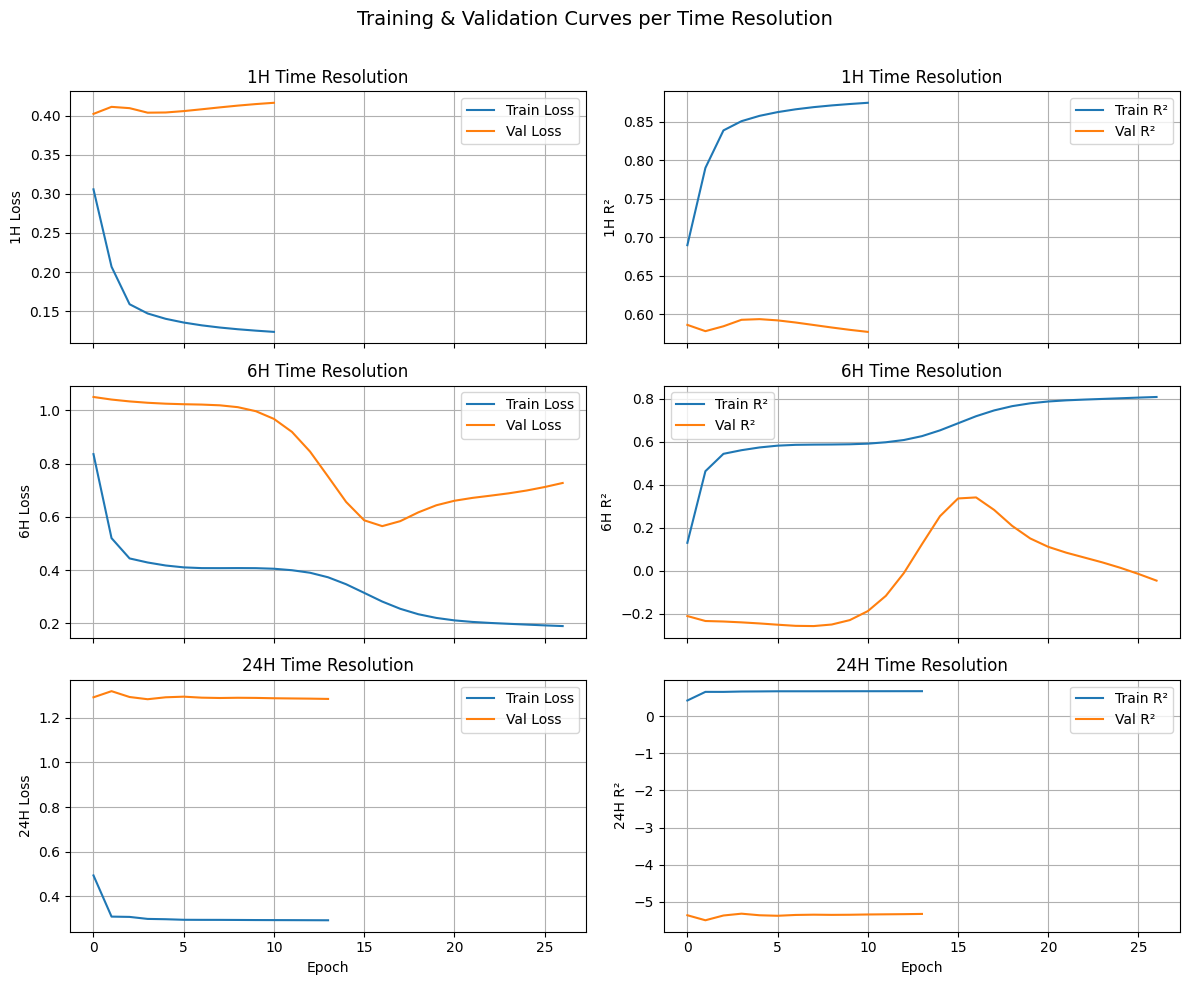

In [ ]:
# plot all learning curves at once
plot_learning_curves_all([history1h_custom_att, history6h_custom_att, history24h_custom_att], ["1H", "6H", "24H"])

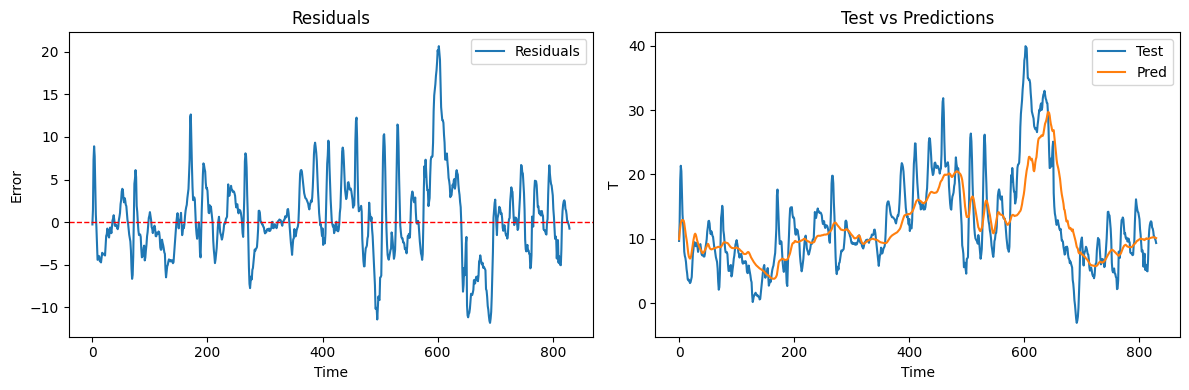


1H series (1 steps-ahead forecasts)
1H Custom Attention Training Time: 68.6994
1H Custom Attention: MAE=3.46, RMSE=4.78, MAPE=55.44


In [ ]:
# 1H 1-step ahead preds
att1h_1h_last_norm, att1h_1h_true_last_norm, _, _ = predict_custom_attention(hour_test_loader, history1h_custom_att['params'])

# denormalize, plot and evaluate
att1h_1h_preds = denormalize(att1h_1h_last_norm, hour_mean, hour_std)
att1h_1h_trues = denormalize(att1h_1h_true_last_norm, hour_mean, hour_std)
plot_residuals_preds(att1h_1h_trues, att1h_1h_preds)
mae1, rmse1, mape1 = evaluate_model(att1h_1h_trues, att1h_1h_preds)

print("\n1H series (1 steps-ahead forecasts)")
print(f"1H Custom Attention Training Time: {history1h_custom_att['total_training_time']}")
print(f"1H Custom Attention: MAE={mae1}, RMSE={rmse1}, MAPE={mape1}")

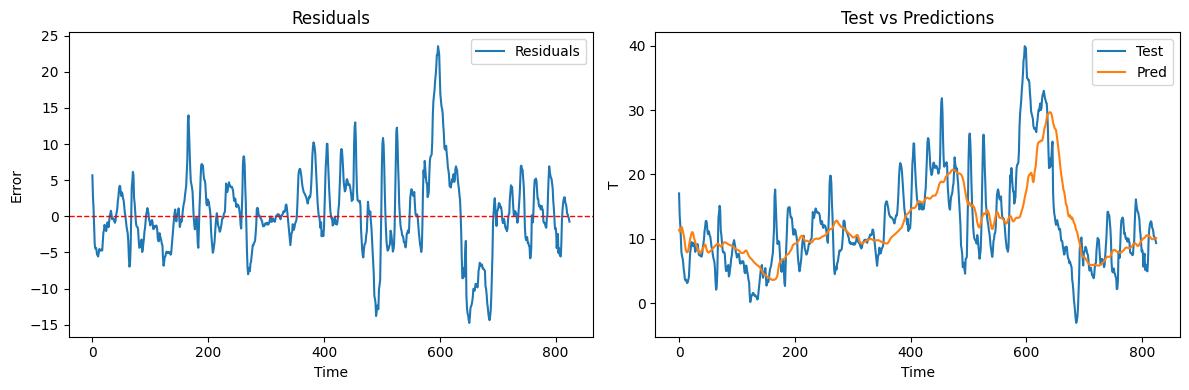


1H series (6 steps-ahead forecasts)
1H Custom Attention Training Time: 68.6994
1H Custom Attention: MAE=4.00, RMSE=5.58, MAPE=64.43


In [ ]:
# 1H 6-step ahead preds (we use test dataloader whose targets are the next 6 values per sample)
att1h_6h_last_norm, att1h_6h_true_last_norm, Pn, Tn = predict_custom_attention(hour6_test_loader, history1h_custom_att['params'], n_steps=6)

# denormalize, plot and evaluate
att1h_6h_preds = denormalize(att1h_6h_last_norm, hour_mean, hour_std)
att1h_6h_trues = denormalize(att1h_6h_true_last_norm, hour_mean, hour_std)
plot_residuals_preds(att1h_6h_trues, att1h_6h_preds)
mae16, rmse16, mape16 = evaluate_model(att1h_6h_trues, att1h_6h_preds)

print("\n1H series (6 steps-ahead forecasts)")
print(f"1H Custom Attention Training Time: {history1h_custom_att['total_training_time']}")
print(f"1H Custom Attention: MAE={mae16}, RMSE={rmse16}, MAPE={mape16}")

In [ ]:
# after predict_custom_attention(..., n_steps=6) on hour loader, preview the full rollouts too
P = denormalize(Pn, hour_mean, hour_std)
T = denormalize(Tn, hour_mean, hour_std)
print("per-step MAE:", np.mean(np.abs(P - T), axis=0))

per-step MAE: [3.48072282 3.65436741 3.75976615 3.83024089 3.91514057 3.99650526]


In [ ]:
# see some examples of preds with its corresponding true values
print(att1h_1h_preds[0], att1h_1h_trues[0])
print(att1h_6h_preds[0], att1h_6h_trues[5])

9.93787999395938 9.66671089251817
11.372981557479209 7.343985835584242


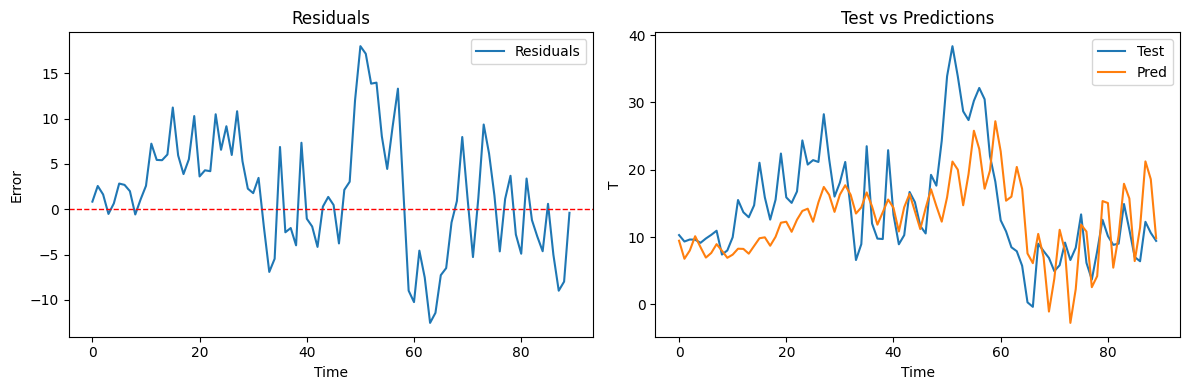


6H series (1 steps-ahead forecasts)
6H Custom Attention Training Time: 26.2441
6H Custom Attention: MAE=5.23, RMSE=6.58, MAPE=84.66


In [ ]:
# 6H 1-step ahead preds
att6h_1h_last_norm, att6h_1h_true_last_norm, _, _ = predict_custom_attention(six_test_loader, history6h_custom_att['params'])

# denormalize, plot and evaluate
att6h_1h_preds = denormalize(att6h_1h_last_norm, six_mean, six_std)
att6h_1h_trues = denormalize(att6h_1h_true_last_norm, six_mean, six_std)
plot_residuals_preds(att6h_1h_trues, att6h_1h_preds)
mae6, rmse6, mape6 = evaluate_model(att6h_1h_trues, att6h_1h_preds)

print("\n6H series (1 steps-ahead forecasts)")
print(f"6H Custom Attention Training Time: {history6h_custom_att['total_training_time']}")
print(f"6H Custom Attention: MAE={mae6}, RMSE={rmse6}, MAPE={mape6}")

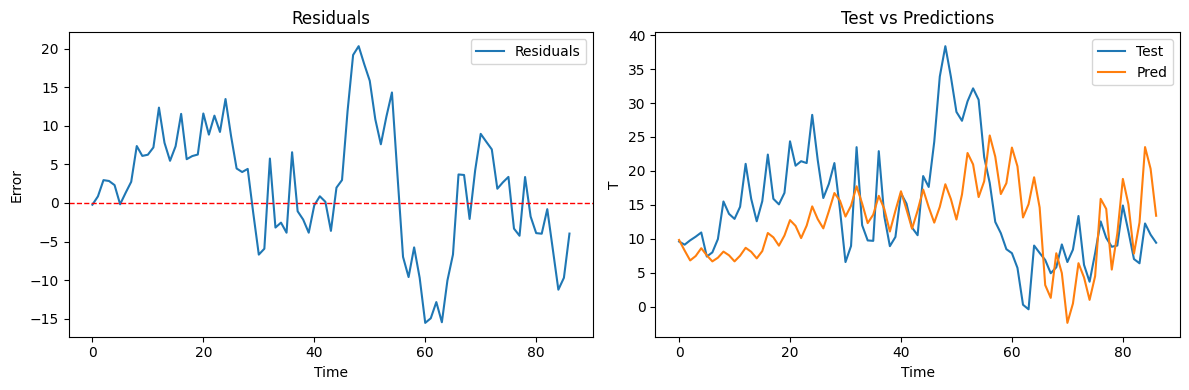


6H series (4 steps-ahead forecasts)
6H Custom Attention Training Time: 26.2441
6H Custom Attention: MAE=6.55, RMSE=8.05, MAPE=144.01


In [ ]:
# 6H 4-step ahead preds
att6h_4h_last_norm, att6h_4h_true_last_norm, _, _ = predict_custom_attention(six4_test_loader, history6h_custom_att['params'], n_steps=4)

# denormalize, plot and evaluate
att6h_4h_preds = denormalize(att6h_4h_last_norm, six_mean, six_std)
att6h_4h_trues = denormalize(att6h_4h_true_last_norm, six_mean, six_std)
plot_residuals_preds(att6h_4h_trues, att6h_4h_preds)
mae64, rmse64, mape64 = evaluate_model(att6h_4h_trues, att6h_4h_preds)

print("\n6H series (4 steps-ahead forecasts)")
print(f"6H Custom Attention Training Time: {history6h_custom_att['total_training_time']}")
print(f"6H Custom Attention: MAE={mae64}, RMSE={rmse64}, MAPE={mape64}")

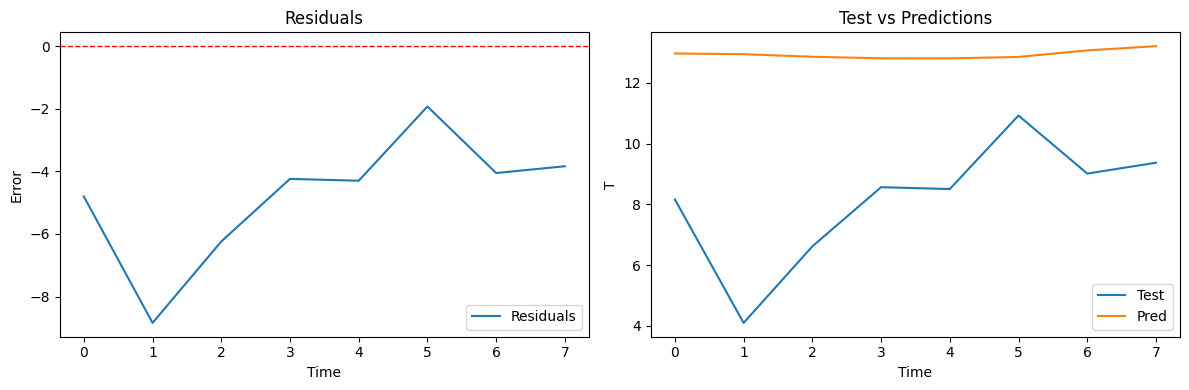


24H series (1 steps-ahead forecasts)
24H Custom Attention Training Time: 3.2191
24H Custom Attention: MAE=4.78, RMSE=5.14, MAPE=71.59


In [ ]:
# 24H 1-step ahead preds
att24h_1h_last_norm, att24h_1h_true_last_norm, _, _ = predict_custom_attention(day_test_loader, history24h_custom_att['params'])

# denormalize, plot and evaluate
att24h_1h_preds = denormalize(att24h_1h_last_norm, day_mean, day_std)
att24h_1h_trues = denormalize(att24h_1h_true_last_norm, day_mean, day_std)
plot_residuals_preds(att24h_1h_trues, att24h_1h_preds)
mae24, rmse24, mape24 = evaluate_model(att24h_1h_trues, att24h_1h_preds)

print("\n24H series (1 steps-ahead forecasts)")
print(f"24H Custom Attention Training Time: {history24h_custom_att['total_training_time']}")
print(f"24H Custom Attention: MAE={mae24}, RMSE={rmse24}, MAPE={mape24}")

In [ ]:
# store all results from custom attention
columns = ["Model", "Resolution", "Horizon", "Target Variable", "Input Type", "MAE", "RMSE", "MAPE (%)", "Fit Time", "# Params"]

att_results = [
    ("Custom Attention", "1-hour", "t+1", "T_mean", "Univariate", mae1, rmse1, mape1, history1h_custom_att['total_training_time'], history1h_custom_att['total_params']),
    ("Custom Attention", "1-hour", "t+6", "T_mean", "Univariate", mae16, rmse16, mape16, history1h_custom_att['total_training_time'], history1h_custom_att['total_params']),
    ("Custom Attention", "6-hour", "t+1", "T_mean", "Univariate", mae6, rmse6, mape6, history6h_custom_att['total_training_time'], history6h_custom_att['total_params']),
    ("Custom Attention", "6-hour", "t+4", "T_mean", "Univariate", mae64, rmse64, mape64, history6h_custom_att['total_training_time'], history6h_custom_att['total_params']),
    ("Custom Attention", "24-hour", "t+1", "T_mean", "Univariate", mae24, rmse24, mape24, history24h_custom_att['total_training_time'], history24h_custom_att['total_params'])
]

In [ ]:
# print the results
print(tabulate(att_results, headers=columns, tablefmt="github", floatfmt=".2f"))

| Model            | Resolution   | Horizon   | Target Variable   | Input Type   |   MAE |   RMSE |   MAPE (%) |   Fit Time |   # Params |
|------------------|--------------|-----------|-------------------|--------------|-------|--------|------------|------------|------------|
| Custom Attention | 1-hour       | t+1       | T_mean            | Univariate   |  3.46 |   4.78 |      55.44 |      68.70 |        817 |
| Custom Attention | 1-hour       | t+6       | T_mean            | Univariate   |  4.00 |   5.58 |      64.43 |      68.70 |        817 |
| Custom Attention | 6-hour       | t+1       | T_mean            | Univariate   |  5.23 |   6.58 |      84.66 |      26.24 |        945 |
| Custom Attention | 6-hour       | t+4       | T_mean            | Univariate   |  6.55 |   8.05 |     144.01 |      26.24 |        945 |
| Custom Attention | 24-hour      | t+1       | T_mean            | Univariate   |  4.78 |   5.14 |      71.59 |       3.22 |        497 |


### Pytorch Self-Attention

In [ ]:
# attention head module
class AttentionHead(nn.Module):
  """
  Implements a single attention head for self-attention.
  """
  def __init__(self, input_dim, model_dim, seq_len):
    super(AttentionHead, self).__init__()
    self.input_dim = input_dim
    self.model_dim = model_dim  # d_k (attention head size)
    self.seq_len = seq_len
    self.device = device

    self.W_q = nn.Parameter(torch.randn(input_dim, model_dim))
    self.W_k = nn.Parameter(torch.randn(input_dim, model_dim))
    self.W_v = nn.Parameter(torch.randn(input_dim, model_dim))

  def forward(self, x):
    # x: (batch_size, seq_len)
    x = x.unsqueeze(-1)  # (batch_size, seq_len, 1)

    query = x @ self.W_q  # (batch_size, seq_len, d_model)
    key = x @ self.W_k
    value = x @ self.W_v

    scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.model_dim, dtype=torch.float32))

    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, value)  # (batch_size, seq_len, d_model)

    return output, attn_weights

# nn with attention head
class nn_mod_att(nn.Module):
  """
  Implements a simple neaural network with modular self-attention.
  """
  def __init__(self, input_dim, model_dim, seq_len):
    super(nn_mod_att, self).__init__()
    self.attention_head = AttentionHead(input_dim, model_dim, seq_len)
    self.fc = nn.Linear(seq_len * model_dim, 1)

  def forward(self, x):
    attn_output, attn_weights = self.attention_head(x)  # (batch_size, seq_len, model_dim)
    attn_output_flat = attn_output.view(attn_output.size(0), -1)  # (batch_size, seq_len * model_dim)
    # print("attn_output shape:", attn_output.shape)
    # print("attn_output_flat shape:", attn_output_flat.shape)
    # print("fc weight shape:", self.fc.weight.shape)
    out = self.fc(attn_output_flat)  # (batch_size, 1)

    return out.squeeze(), attn_weights


# training function for nn_mod_att class-based model
def train_nn_mod_att_class(model, train_loader, val_loader, epochs=100, lr=1e-4, weight_decay=1e-4, patience=10, verbose_every=10):
  """
  Trains a PyTorch class-based attention model (nn_mod_att) on univariate time series.

  Args:
      - model: an instance of nn_mod_att
      - train_loader: PyTorch DataLoader for training data
      - val_loader: PyTorch DataLoader for validation data
      - epochs: int, number of training epochs
      - lr: float, learning rate
      - weight_decay: float, L2 regularization strength
      - patience: int, early stopping patience
      - verbose_every: int, print training progress every n epochs

  Returns:
      - history: dictionary with training metrics, trained model, time, etc.
  """
  # ensure using gpu, if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  loss_fn = nn.MSELoss()

  history = {'train_loss': [], 'val_loss': [], 'train_r2': [], 'val_r2': []}

  best_val_loss = float("inf")
  best_state = {k: v.clone() for k, v in model.state_dict().items()}
  no_improve = 0
  stopped_epoch = epochs

  # train step
  start_time = time.time()
  for epoch in range(epochs):
    model.train()

    train_preds, train_targets = [], []
    total_loss = 0.0

    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      preds, _ = model(X_batch)
      preds = preds.view(-1) # (B,)

      y_batch = y_batch.view(-1) # (B,)
      loss = loss_fn(preds, y_batch)

      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
      optimizer.step()

      train_preds.extend(preds.detach().cpu().numpy())
      train_targets.extend(y_batch.detach().cpu().numpy())
      total_loss += loss.item()

    avg_train_loss = total_loss / max(1, len(train_loader))
    train_r2 = r2_fn(train_targets, train_preds)

    # validation step
    model.eval()
    val_preds, val_targets = [], []
    val_loss = 0.0

    with torch.no_grad():
      for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        preds, _ = model(X_batch)
        preds = preds.view(-1) # (B,)

        y_batch = y_batch.view(-1) # (B,)
        loss = loss_fn(preds, y_batch)

        val_preds.extend(preds.detach().cpu().numpy())
        val_targets.extend(y_batch.detach().cpu().numpy())
        val_loss += loss.item()

    avg_val_loss = val_loss / max(1, len(val_loader))
    val_r2 = r2_fn(val_targets, val_preds)

    # log the metrics
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_r2'].append(train_r2)
    history['val_r2'].append(val_r2)

    if (epoch + 1) % verbose_every == 0:
      print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train R²: {train_r2:.4f} | Val Loss: {avg_val_loss:.4f}, Val R²: {val_r2:.4f}")

    # early stopping on best val loss
    if avg_val_loss < best_val_loss - 1e-8:
      best_val_loss = avg_val_loss
      best_state = {k: v.clone() for k, v in model.state_dict().items()}
      no_improve = 0
    else:
      no_improve += 1
      if no_improve >= patience:
        stopped_epoch = epoch
      break

  total_time = time.time() - start_time
  print(f"\nTraining complete in {total_time:.2f}seconds")

  total_params = count_trainable_params(model.parameters())
  print(f"Total trainable parameters: {total_params}")

  # restore best weights
  model.load_state_dict(best_state)

  history.update({
      "params": best_state, # best model state_dict
      "model": model, # returned model (best weights loaded)
      "total_training_time": round(total_time, 4),
      "total_params": total_params,
      "best_val_loss": float(best_val_loss),
      "stopped_epoch": stopped_epoch,
    })

  return history

# prediction function for nn modular-based models
@torch.no_grad()
def predict_nn_mod(model, test_loader, n_steps=1):
  """
  Rolling-forecast predictions for ANY modular model that accepts (B, L, 1) and returns y_hat shaped (B, 1) or (B,) (optionally with extra outputs).

  Args:
      model: PyTorch model
      test_loader: PyTorch DataLoader for test data
      n_steps: int, number of steps ahead to predict

  Returns:
      preds_last: (N,) last-step predictions
      trues_last: (N,) or None
      preds_rollout: (N, n_steps)
      trues_rollout: (N, n_steps) or None
  """
  model.eval()
  device = next(model.parameters()).device

  preds_last, trues_last = [], []
  preds_rollout, trues_rollout = [], []

  for batch in test_loader:
    if isinstance(batch, (list, tuple)) and len(batch) == 2:
      Xb, yb = batch
      yb = yb.to(device)
    else:
      Xb, yb = batch, None

    Xb = Xb.to(device)  # (B, L, 1)
    B = Xb.size(0)

    for i in range(B):
      seq = Xb[i:i+1].clone()  # (1, L, 1)
      step_preds = []

      for _ in range(n_steps):
        out = model(seq)
        # handle models that return (y_hat, extras)
        if isinstance(out, (tuple, list)):
          out = out[0]
        y_val = float(out.squeeze().item())
        step_preds.append(y_val)

        # autoregressive feedback
        next_in = torch.tensor([[[y_val]]], dtype=seq.dtype, device=device) # (1,1,1)
        seq = torch.cat([seq[:, 1:], next_in], dim=1) # (1,L,1)

      preds_rollout.append(step_preds)
      preds_last.append(step_preds[-1])

      if yb is not None:
        yi = yb[i].view(-1)  # (1,) or (H,)
        if yi.numel() >= n_steps:
          tgt = yi[:n_steps].detach().cpu().numpy().astype(float).tolist()
        else:
          tgt = yi.detach().cpu().numpy().astype(float).tolist()
        trues_rollout.append(tgt)
        trues_last.append(float(tgt[-1]))

  preds_last = np.asarray(preds_last, dtype=float)
  trues_last = np.asarray(trues_last, dtype=float) if trues_last else None
  preds_rollout = np.asarray(preds_rollout, dtype=float)
  trues_rollout = np.asarray(trues_rollout, dtype=float) if trues_rollout else None

  return preds_last, trues_last, preds_rollout, trues_rollout

In [ ]:
# define nn_att_models for all time resolutions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hour_nn_att_model = nn_mod_att(input_dim=1, model_dim=16, seq_len=hour_window_size).to(device)
six_nn_att_model = nn_mod_att(input_dim=1, model_dim=16, seq_len=six_window_size).to(device)
daily_nn_att_model = nn_mod_att(input_dim=1, model_dim=16, seq_len=day_window_size).to(device)

In [ ]:
print("Training NN with modular self-attention for 1H resolution")
mod_att1h_history = train_nn_mod_att_class(hour_nn_att_model, hour_train_loader, hour_val_loader)

print("\nTraining NN with modular self-attention for 6H resolution")
mod_att6h_history = train_nn_mod_att_class(six_nn_att_model, six_train_loader, six_val_loader)

print("\nTraining NN with modular self-attention for 24H resolution")
mod_att24h_history = train_nn_mod_att_class(daily_nn_att_model, day_train_loader, day_val_loader)

Training NN with modular self-attention for 1H resolution
Epoch 10/100, Train Loss: 0.0123, Train R²: 0.9875 | Val Loss: 0.0219, Val R²: 0.9778
Epoch 20/100, Train Loss: 0.0097, Train R²: 0.9901 | Val Loss: 0.0170, Val R²: 0.9826
Epoch 30/100, Train Loss: 0.0086, Train R²: 0.9912 | Val Loss: 0.0155, Val R²: 0.9842
Epoch 40/100, Train Loss: 0.0081, Train R²: 0.9917 | Val Loss: 0.0145, Val R²: 0.9852
Epoch 50/100, Train Loss: 0.0079, Train R²: 0.9920 | Val Loss: 0.0140, Val R²: 0.9857
Epoch 60/100, Train Loss: 0.0077, Train R²: 0.9922 | Val Loss: 0.0137, Val R²: 0.9860
Epoch 70/100, Train Loss: 0.0076, Train R²: 0.9923 | Val Loss: 0.0135, Val R²: 0.9862
Epoch 80/100, Train Loss: 0.0076, Train R²: 0.9923 | Val Loss: 0.0134, Val R²: 0.9863
Epoch 90/100, Train Loss: 0.0075, Train R²: 0.9924 | Val Loss: 0.0133, Val R²: 0.9864
Epoch 100/100, Train Loss: 0.0075, Train R²: 0.9924 | Val Loss: 0.0132, Val R²: 0.9865

Training complete in 56.89seconds
Total trainable parameters: 817

Training NN w

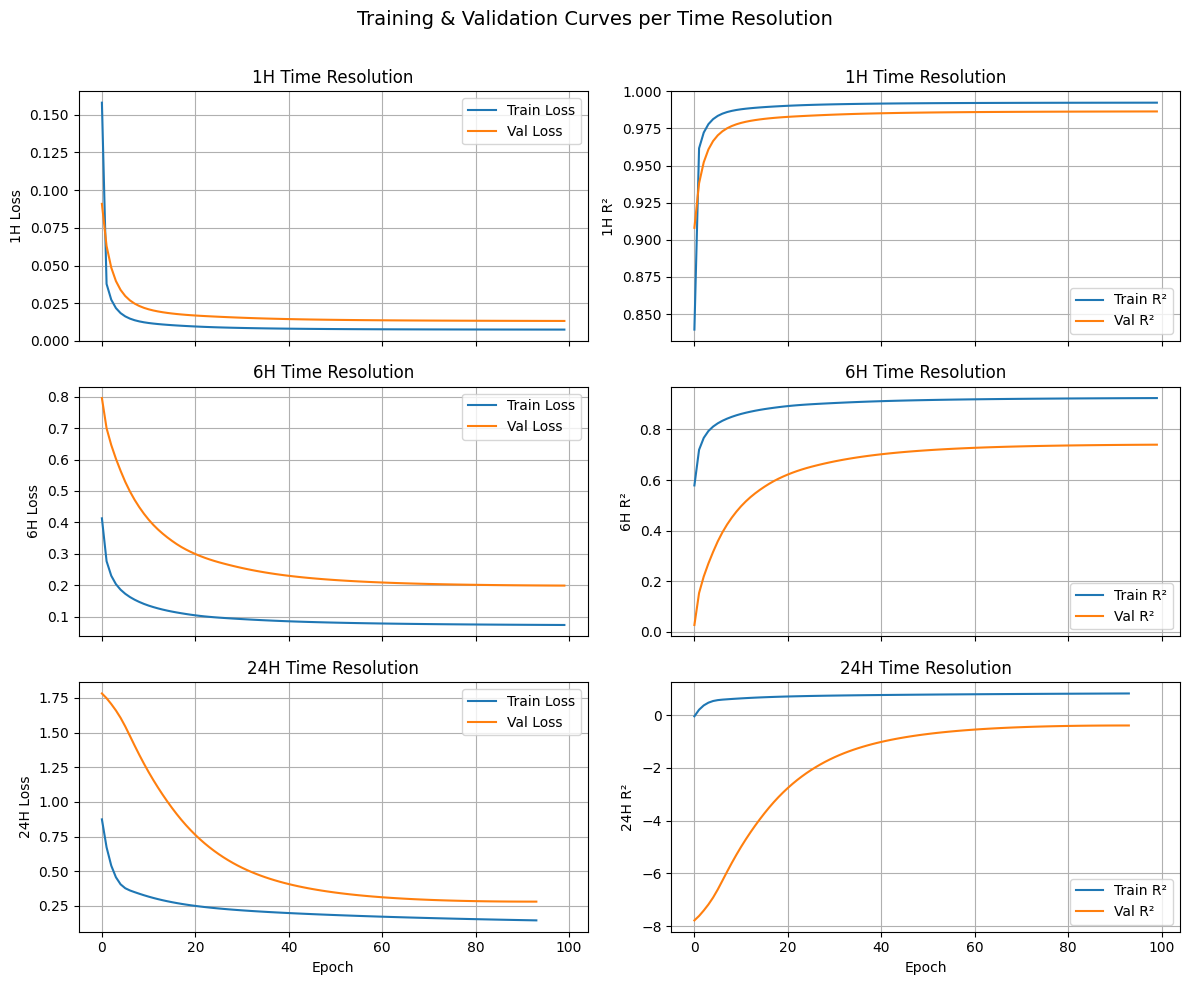

In [ ]:
# plot all learning curves
plot_learning_curves_all([mod_att1h_history, mod_att6h_history, mod_att24h_history], ["1H", "6H", "24H"])

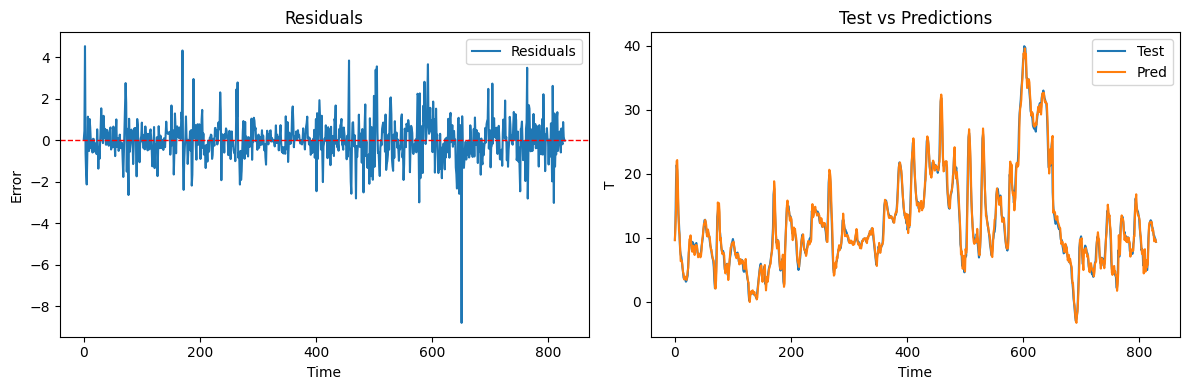


1H series (1 steps-ahead forecasts)
1H Modular Attention Training Time: 56.8882
1H Modular Attention: MAE=0.67, RMSE=0.98, MAPE=8.44


In [ ]:
# 1H 1-step ahead preds
hour_preds_mod_att_norm, hour_trues_norm, _, _ = predict_nn_mod(mod_att1h_history["model"], hour_test_loader)

# denormalize, plot and evaluate
hour_preds_mod_att = denormalize(hour_preds_mod_att_norm, hour_mean, hour_std)
hour_trues = denormalize(hour_trues_norm, hour_mean, hour_std)
plot_residuals_preds(hour_trues, hour_preds_mod_att)
mod_mae1, mod_rmse1, mod_mape1 = evaluate_model(hour_trues, hour_preds_mod_att)

print("\n1H series (1 steps-ahead forecasts)")
print(f"1H Modular Attention Training Time: {mod_att1h_history['total_training_time']}")
print(f"1H Modular Attention: MAE={mod_mae1}, RMSE={mod_rmse1}, MAPE={mod_mape1}")

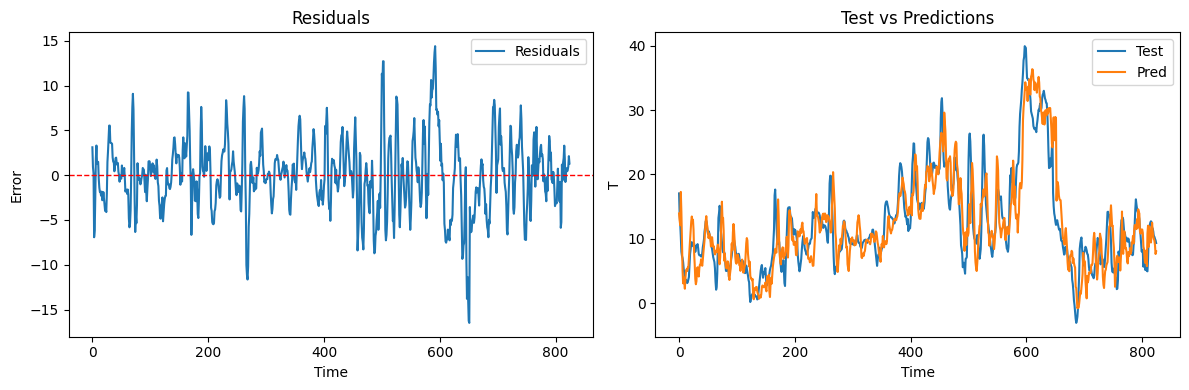


1H series (6 steps-ahead forecasts)
1H Modular Attention: MAE=2.96, RMSE=3.97, MAPE=40.12


In [ ]:
# 1H 6-step ahead preds (we use test dataloader whose targets are the next 6 values per sample)
hour6h_preds_mod_att_norm, hour6h_trues_norm, Pn, Tn = predict_nn_mod(mod_att1h_history["model"], hour6_test_loader, n_steps=6)

# denormalize, plot and evaluate
hour6h_preds_mod_att = denormalize(hour6h_preds_mod_att_norm, hour_mean, hour_std)
hour6h_trues = denormalize(hour6h_trues_norm, hour_mean, hour_std)
plot_residuals_preds(hour6h_trues, hour6h_preds_mod_att)
mod_mae16, mod_rmse16, mod_mape16 = evaluate_model(hour6h_trues, hour6h_preds_mod_att)

print("\n1H series (6 steps-ahead forecasts)")
print(f"1H Modular Attention: MAE={mod_mae16}, RMSE={mod_rmse16}, MAPE={mod_mape16}")

In [ ]:
# see some examples of preds with its corresponding true values
print(hour_preds_mod_att[0], hour_trues[0])
print(hour6h_preds_mod_att[0], hour6h_trues[0])

9.595093347006685 9.66671089251817
13.929830232881764 17.045765889441146


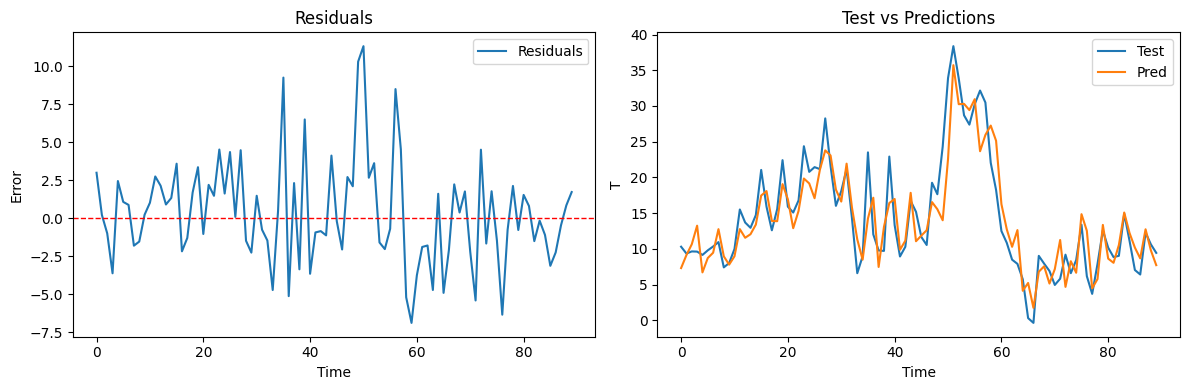


6H series (1 steps-ahead forecasts)
6H Modular Attention Training Time: 9.125
6H Modular Attention: MAE=2.62, RMSE=3.43, MAPE=44.74


In [ ]:
# 6H 1-step ahead preds
six_preds_mod_att_norm, six_trues_norm, _, _ = predict_nn_mod(mod_att6h_history["model"], six_test_loader)

# denormalize, plot and evaluate
six_preds_mod_att = denormalize(six_preds_mod_att_norm, six_mean, six_std)
six_trues = denormalize(six_trues_norm, six_mean, six_std)
plot_residuals_preds(six_trues, six_preds_mod_att)
mod_mae6, mod_rmse6, mod_mape6 = evaluate_model(six_trues, six_preds_mod_att)

print("\n6H series (1 steps-ahead forecasts)")
print(f"6H Modular Attention Training Time: {mod_att6h_history['total_training_time']}")
print(f"6H Modular Attention: MAE={mod_mae6}, RMSE={mod_rmse6}, MAPE={mod_mape6}")

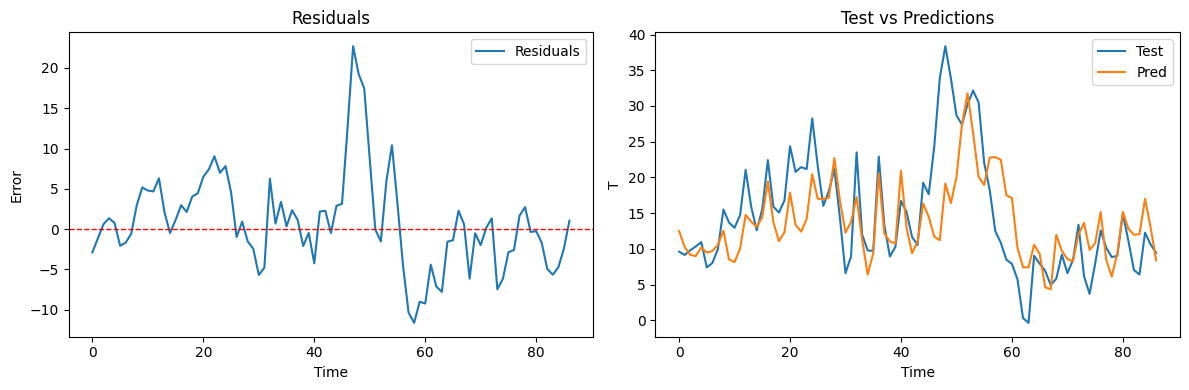


6H series (4 steps-ahead forecasts)
6H Modular Attention: MAE=4.24, RMSE=5.95, MAPE=82.49


In [ ]:
# 6H 4-step ahead preds (we use test dataloader whose targets are the next 4 values per sample)
six4h_preds_mod_att_norm, six4h_trues_norm, Pn, Tn = predict_nn_mod(mod_att6h_history["model"], six4_test_loader, n_steps=4)

# denormalize, plot and evaluate
six4h_preds_mod_att = denormalize(six4h_preds_mod_att_norm, six_mean, six_std)
six4h_trues = denormalize(six4h_trues_norm, six_mean, six_std)
plot_residuals_preds(six4h_trues, six4h_preds_mod_att)
mod_mae64, mod_rmse64, mod_mape64 = evaluate_model(six4h_trues, six4h_preds_mod_att)

print("\n6H series (4 steps-ahead forecasts)")
print(f"6H Modular Attention: MAE={mod_mae64}, RMSE={mod_rmse64}, MAPE={mod_mape64}")

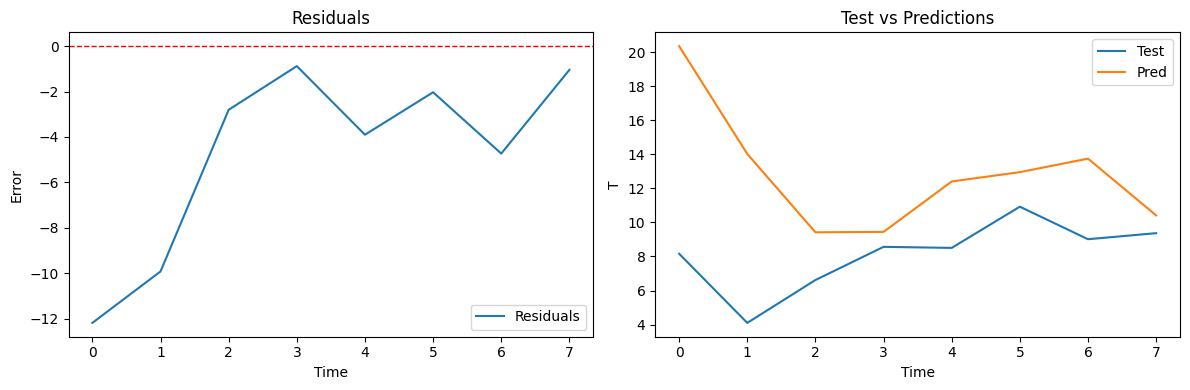


24H series (1 steps-ahead forecasts)
24H Modular Attention Training Time: 2.1858
24H Modular Attention: MAE=4.69, RMSE=6.11, MAPE=71.54


In [ ]:
# 24H 1-step ahead preds
day_preds_mod_att_norm, day_trues_norm, _, _ = predict_nn_mod(mod_att24h_history["model"], day_test_loader)

# denormalize, plot and evaluate
day_preds_mod_att = denormalize(day_preds_mod_att_norm, day_mean, day_std)
day_trues = denormalize(day_trues_norm, day_mean, day_std)
plot_residuals_preds(day_trues, day_preds_mod_att)
mod_mae24, mod_rmse24, mod_mape24 = evaluate_model(day_trues, day_preds_mod_att)

print("\n24H series (1 steps-ahead forecasts)")
print(f"24H Modular Attention Training Time: {mod_att24h_history['total_training_time']}")
print(f"24H Modular Attention: MAE={mod_mae24}, RMSE={mod_rmse24}, MAPE={mod_mape24}")

In [ ]:
att_results += [
    ("Modular Attention", "1-hour", "t+1", "T_mean", "Univariate", mod_mae1, mod_rmse1, mod_mape1, mod_att1h_history['total_training_time'], mod_att1h_history['total_params']),
    ("Modular Attention", "1-hour", "t+6", "T_mean", "Univariate", mod_mae16, mod_rmse16, mod_mape16, mod_att1h_history['total_training_time'], mod_att1h_history['total_params']),
    ("Modular Attention", "6-hour", "t+1", "T_mean", "Univariate", mod_mae6, mod_rmse6, mod_mape6, mod_att6h_history['total_training_time'], mod_att6h_history['total_params']),
    ("Modular Attention", "6-hour", "t+4", "T_mean", "Univariate", mod_mae64, mod_rmse64, mod_mape64, mod_att6h_history['total_training_time'], mod_att6h_history['total_params']),
    ("Modular Attention", "24-hour", "t+1", "T_mean", "Univariate", mod_mae24, mod_rmse24, mod_mape24, mod_att24h_history['total_training_time'], mod_att24h_history['total_params'])
]

In [ ]:
# print all attention results
print(tabulate(att_results, headers=columns, tablefmt="github", floatfmt=".2f"))

| Model             | Resolution   | Horizon   | Target Variable   | Input Type   |   MAE |   RMSE |   MAPE (%) |   Fit Time |   # Params |
|-------------------|--------------|-----------|-------------------|--------------|-------|--------|------------|------------|------------|
| Custom Attention  | 1-hour       | t+1       | T_mean            | Univariate   |  3.46 |   4.78 |      55.44 |      68.70 |        817 |
| Custom Attention  | 1-hour       | t+6       | T_mean            | Univariate   |  4.00 |   5.58 |      64.43 |      68.70 |        817 |
| Custom Attention  | 6-hour       | t+1       | T_mean            | Univariate   |  5.23 |   6.58 |      84.66 |      26.24 |        945 |
| Custom Attention  | 6-hour       | t+4       | T_mean            | Univariate   |  6.55 |   8.05 |     144.01 |      26.24 |        945 |
| Custom Attention  | 24-hour      | t+1       | T_mean            | Univariate   |  4.78 |   5.14 |      71.59 |       3.22 |        497 |
| Modular Attention 

## Transformer - Encoder

### Introduction to Transformer-Encoder

We start by applying the encoder pipeline to two input samples to visualize how the inputs and outputs transform through each component, and then generalize the process to the entire dataset.

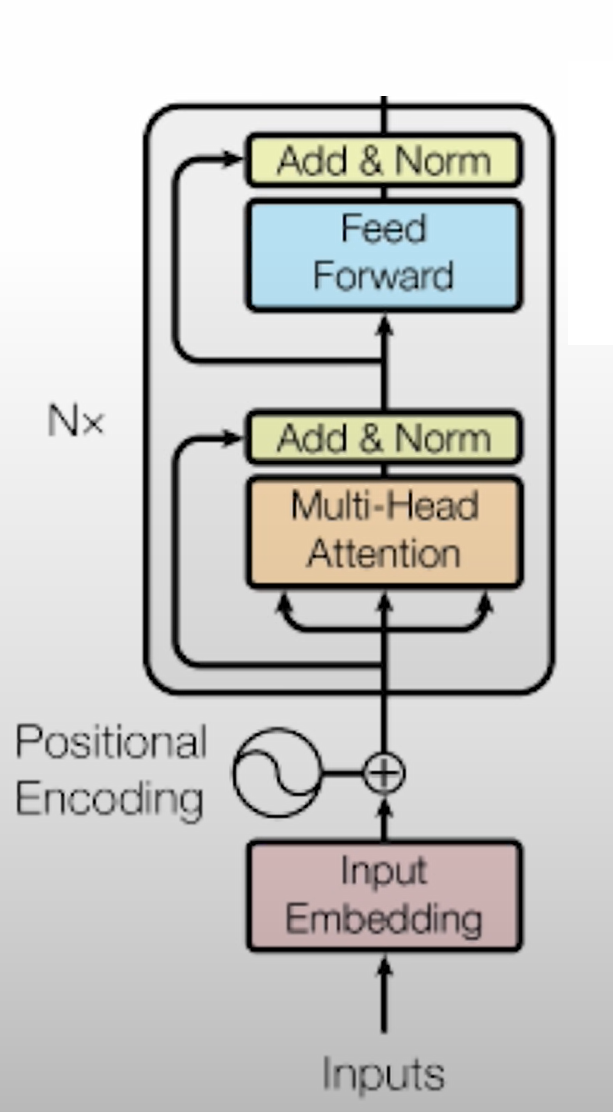

In [ ]:
# pick another batch and retrieve two first samples
print("\nA batch consists of X, y:")
batch2 = next(iter(day_train_loader))
# print("Batch type:", type(batch2))
X, y = batch2
print("X dtype:", X.dtype, "y dtype:", y.dtype)
print("X shape:", X.shape, "y shape:", y.shape)

# (first sample)
x1 = X[0].squeeze()
y1 = y[0].squeeze()
print("\nFirst sample (sequence) and its label:\n", x1, y1)
print("\nFirst sample's features (X) and label (y) shapes:", x1.shape, y1.shape)

# (second sample)
x2 = X[1].squeeze()
y2 = y[1].squeeze()
print("\nSecond@ sample (sequence) and its label:\n", x2, y2)
print("\nSecond sample's features (X) and label (y) shapes:", x2.shape, y2.shape)

# put them together in a dummy batch
x = torch.stack([x1, x2]) # shape: (2, 28)
y = torch.stack([y1, y2]) # shape: (2,)
print("\nCombined 2 sequences into a dummy mini-batch):\n")
print(x, x.shape)
print(y, y.shape)


A batch consists of X, y:
X dtype: torch.float32 y dtype: torch.float32
X shape: torch.Size([32, 28, 1]) y shape: torch.Size([32, 1])

First sample (sequence) and its label:
 tensor([-1.9179, -2.0006, -1.1025, -1.2626, -1.4227, -1.4365, -1.4675, -1.1027,
        -0.6862, -0.5701, -1.3231, -1.4975, -1.2245, -0.7284, -0.3307, -0.5375,
        -1.0937, -1.1204, -1.4570, -1.4763, -2.0421, -2.0459, -1.7195, -2.0970,
        -2.2519, -2.0224, -1.1407, -1.1394]) tensor(-1.3528)

First sample's features (X) and label (y) shapes: torch.Size([28]) torch.Size([])

Second@ sample (sequence) and its label:
 tensor([-2.0006, -1.1025, -1.2626, -1.4227, -1.4365, -1.4675, -1.1027, -0.6862,
        -0.5701, -1.3231, -1.4975, -1.2245, -0.7284, -0.3307, -0.5375, -1.0937,
        -1.1204, -1.4570, -1.4763, -2.0421, -2.0459, -1.7195, -2.0970, -2.2519,
        -2.0224, -1.1407, -1.1394, -1.3528]) tensor(-0.9861)

Second sample's features (X) and label (y) shapes: torch.Size([28]) torch.Size([])

Combined 2 

In [ ]:
print("First sequence, first timestep (before any processing):")
print(x[0][0], x[0][0].shape)  # a scalar

First sequence, first timestep (before any processing):
tensor(-1.9179) torch.Size([])


In [ ]:
# set the model's dimensionality (the dimensions in which we will extent the sequence)
d_model = 8

# reshape input x: (batch_size, seq_len) → (batch_size, seq_len, 1)
# (add a feature dimension so each scalar timestep can be projected to more dimensions (d_model) via a linear layer
x = x.unsqueeze(-1) # shape: (2, 28, 1)
print("Reshaped input x:")
print(x, x.shape)

# 'embedding process' -> extend to more dimensions by creating a learnable linear projection layer from 1 → d_model
pos_emb = nn.Linear(1, d_model)

# project x to d_model dimensions
x_proj_emb = pos_emb(x)  # shape: (2, 28, 8)
print("\nAfter input projection (Linear(1 → d_model)):")
print("Projected x shape:", x_proj_emb.shape)  # should be (2, 28, 8)

print("\nLearnable parameters of this linear embedding layer:")
print("Total parameters:", count_trainable_params(pos_emb.parameters()))
print("\nWeights:", pos_emb.weight)  # should be (8, 1)
print("Biases:", pos_emb.bias)  # should be (8,)

Reshaped input x:
tensor([[[-1.9179],
         [-2.0006],
         [-1.1025],
         [-1.2626],
         [-1.4227],
         [-1.4365],
         [-1.4675],
         [-1.1027],
         [-0.6862],
         [-0.5701],
         [-1.3231],
         [-1.4975],
         [-1.2245],
         [-0.7284],
         [-0.3307],
         [-0.5375],
         [-1.0937],
         [-1.1204],
         [-1.4570],
         [-1.4763],
         [-2.0421],
         [-2.0459],
         [-1.7195],
         [-2.0970],
         [-2.2519],
         [-2.0224],
         [-1.1407],
         [-1.1394]],

        [[-2.0006],
         [-1.1025],
         [-1.2626],
         [-1.4227],
         [-1.4365],
         [-1.4675],
         [-1.1027],
         [-0.6862],
         [-0.5701],
         [-1.3231],
         [-1.4975],
         [-1.2245],
         [-0.7284],
         [-0.3307],
         [-0.5375],
         [-1.0937],
         [-1.1204],
         [-1.4570],
         [-1.4763],
         [-2.0421],
         [-2.0459],


In [ ]:
# display first sequence, first timestep
print("First sequence, first timestep (after adding embeddings):")
print(x_proj_emb[0][0], x_proj_emb[0][0].shape)  # a vector of length d_model (8,)

First sequence, first timestep (after adding embeddings):
tensor([ 0.8962,  2.4503, -1.7809, -1.4028, -0.0868, -0.9992, -0.5641, -1.2700],
       grad_fn=<SelectBackward0>) torch.Size([8])


After the embedding layer, **Positional Encodings** are added. The original paper (“Attention is All You Need”) defines it as:

$P_{(pos,\, 2i)} = \sin\left(\frac{pos}{n^{\frac{2i}{d}}}\right)$
$P_{(pos,\, 2i+1)} = \cos\left(\frac{pos}{n^{\frac{2i}{d}}}\right)$,

where:

$L$: the length of the sequence,

$pos$: position of an object in the input sequence, $0 \leq pos < L/2$,

$d$: dimension of the output embedding space,

$i$: used for mapping to column indices $0 \leq i < d/2$, with a single value of maps to both sine and cosine functions

In [ ]:
def get_positional_encoding(seq_len, d_model, n=10000):
  """
  Generates a sinusoidal positional encoding matrix.

  Args:
      seq_len (int): Length of the sequence (e.g. 24)
      d_model (int): Dimensionality of embeddings (e.g. 8)
      n (int): Base for the frequency scaling (default 10000, as in the original paper)

  Returns:
      torch.Tensor: Positional encoding matrix of shape (seq_len, d_model)
  """
  P = torch.zeros((seq_len, d_model)) # shape: (seq_len, d_model)

  for pos in range(seq_len):
    for i in range(0, d_model // 2):
      denominator = np.power(n, 2*i/d_model)
      P[pos, 2*i] = np.sin(pos/denominator)
      P[pos, 2*i+1] = np.cos(pos/denominator)

  return P

In [ ]:
# create positional encodings for the sequence length and d_model
seq_len = x_proj_emb.shape[1] # 28
d_model = x_proj_emb.shape[2] # 8
pos_encoding = get_positional_encoding(seq_len, d_model)
print("Positional encoding shape:", pos_encoding.shape) # shape: (24, 8)
# print(pos_encoding)

Positional encoding shape: torch.Size([28, 8])


In [ ]:
pos_encoding2 = pos_encoding.squeeze(0)
print(pos_encoding2.shape)

torch.Size([28, 8])


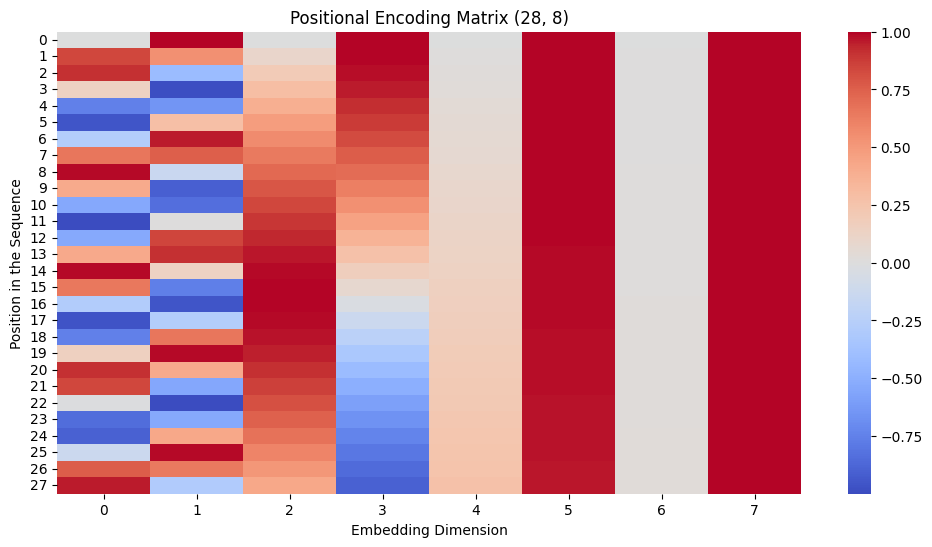

In [ ]:
# plot positional encodings
plt.figure(figsize=(12, 6))
sns.heatmap(pos_encoding2, cmap='coolwarm')
plt.title(f'Positional Encoding Matrix ({seq_len}, {d_model})')
plt.ylabel('Position in the Sequence')
plt.xlabel('Embedding Dimension')
plt.show()

This heatmap shows the `sinusoidal` positional encoding matrix used by the Transformer.
Each row corresponds to a timestep (position) in the sequence, and each column to an embedding dimension.
We observe:
- Lower dimensions (left) have high-frequency fluctuations across time, capturing fine-grained positional changes.
- Higher dimensions (right) change slowly, encoding broader position trends.

This multiscale structure enables the model to learn both local and global temporal patterns.

In [ ]:
# x_proj is of shape (2, 24, 8), so we need to dimension to pos_encoding to be able eto add it to x_proj

# add a batch dimension to pos_encoding -> shape becomes (1, 24, 8)
pos_encoding = pos_encoding.unsqueeze(0)  # shape: (1, 24, 8)
print("Added batch dimension to pos_encoding:", pos_encoding.shape)

# add positional encodings to the projected input (embedded) x_proj
x_proj_enc = x_proj_emb + pos_encoding  # shape: (2, 24, 8)
print("Added positional encodings to the projected input x_proj:", x_proj_enc.shape)

Added batch dimension to pos_encoding: torch.Size([1, 28, 8])
Added positional encodings to the projected input x_proj: torch.Size([2, 28, 8])


In [ ]:
# display now first timestep of first sequence
print("First sequence, first timestep (after adding positional encodings):")
print(x_proj_enc[0][0], x_proj_enc[0][0].shape)  # a vector of length d_model (8,)

# print(x_proj_emb[0][0] == x_proj_enc[0][0])

First sequence, first timestep (after adding positional encodings):
tensor([ 8.9623e-01,  3.4503e+00, -1.7809e+00, -4.0276e-01, -8.6793e-02,
         7.8380e-04, -5.6408e-01, -2.6995e-01], grad_fn=<SelectBackward0>) torch.Size([8])


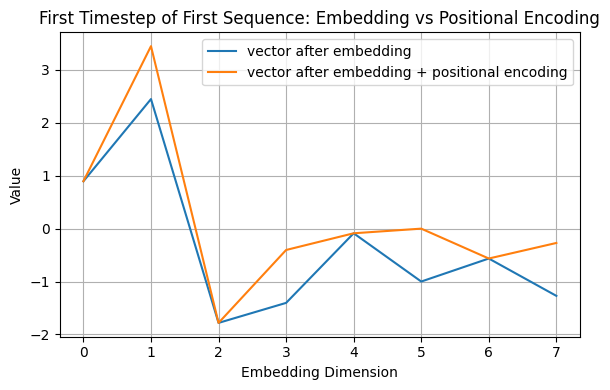

In [ ]:
# plot first sequence, first timestep after embeddings and encodings
plt.figure(figsize=(6, 4))
plt.plot(x_proj_emb[0][0].detach().numpy(), label="vector after embedding")
plt.plot(x_proj_enc[0][0].detach().numpy(), label="vector after embedding + positional encoding")
plt.title("First Timestep of First Sequence: Embedding vs Positional Encoding")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# now, the input for the atatention head is ready, let's see it
print("Input for the attention head:")
print(x_proj_enc, x_proj_enc.shape)

Input for the attention head:
tensor([[[ 8.9623e-01,  3.4503e+00, -1.7809e+00, -4.0276e-01, -8.6793e-02,
           7.8380e-04, -5.6408e-01, -2.6995e-01],
         [ 1.7386e+00,  3.0645e+00, -1.7627e+00, -4.7503e-01, -1.1950e-01,
          -8.7407e-03, -5.4938e-01, -2.8662e-01],
         [ 1.7970e+00,  1.3045e+00, -7.7606e-01,  2.4118e-01,  3.5461e-01,
           9.4075e-02, -6.9722e-01, -1.0549e-01],
         [ 1.0305e+00,  8.7393e-01, -8.3749e-01,  8.6100e-02,  2.8187e-01,
           7.5468e-02, -6.6968e-01, -1.3779e-01],
         [ 1.3422e-01,  1.3535e+00, -9.0181e-01, -7.8473e-02,  2.0915e-01,
           5.6769e-02, -6.4216e-01, -1.7007e-01],
         [-6.7754e-02,  2.3032e+00, -8.2550e-01, -1.3323e-01,  2.1198e-01,
           5.4730e-02, -6.3886e-01, -1.7287e-01],
         [ 6.1208e-01,  3.0075e+00, -7.7096e-01, -2.1075e-01,  2.0593e-01,
           5.0622e-02, -6.3272e-01, -1.7913e-01],
         [ 1.5446e+00,  2.4747e+00, -3.3070e-01,  2.5799e-02,  4.0446e-01,
           9.1804e-0

In [ ]:
# define batch attention head function
def batch_custom_attention_head(x, W_q, W_k, W_v, d_model):
  """
  Applies a custom self-attention head to a batch of input sequences.

  Args:
      x (torch.Tensor): Batch of input sequences of shape (batch_size, seq_len, d_model)
      W_q (torch.nn.Linear): Linear layer for query transformation
      W_k (torch.nn.Linear): Linear layer for key transformation
      W_v (torch.nn.Linear): Linear layer for value transformation
      d_model (int): Dimension of Q, K, V projections (e.g. 8)

  Returns:
      output (torch.Tensor): Batch of output sequences of shape (batch_size, seq_len, d_model)
      attention_weights (torch.Tensor): Attention weights for each input sequence of shape (batch_size, seq_len, seq_len)
  """
  # project input to Q, K, V to create matrices
  Q = W_q(x)  # shape: (batch_size, seq_len, d_model)
  K = W_k(x)
  V = W_v(x)

  # compute attention scores
  # transpose K for dot product: transpose second and third dims, leaving the first batch dim untouched
  scale = d_model ** 0.5
  attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / scale  # shape: (batch_size, seq_len, seq_len)

  # apply softmax to get att weights
  attention_weights = F.softmax(attention_scores, dim=-1)  # shape: (batch_size, seq_len, seq_len)

  # compute the weighted sum of values
  output = torch.matmul(attention_weights, V)  # shape: (batch_size, seq_len, d_model)

  return output, attention_weights

In [ ]:
# attention in practice

# step 1: define Q, K, and V weights
W_q = nn.Linear(d_model, d_model) # shape: (8, 8)
W_k = nn.Linear(d_model, d_model)
W_v = nn.Linear(d_model, d_model)
print("Q, K, V weights shape:", W_q.weight.shape)
print("Learnable parameters for each of (W_q, W_k, W_v):", count_trainable_params([W_q.weight, W_k.bias]))
print("Total parameters:", count_trainable_params([W_q.weight, W_k.bias, W_k.weight, W_k.bias, W_v.weight, W_v.bias]))

# step 2: apply single-head self-attention to x_proj_enc
att_output, att_weights = batch_custom_attention_head(x_proj_enc, W_q, W_k, W_v, d_model)

# check shapes
print("\nAttention output shape:", att_output.shape) # (2, 24, 8)
print("Attention weights shape:", att_weights.shape) # (2, 24, 24)

Q, K, V weights shape: torch.Size([8, 8])
Learnable parameters for each of (W_q, W_k, W_v): 72
Total parameters: 216

Attention output shape: torch.Size([2, 28, 8])
Attention weights shape: torch.Size([2, 28, 28])


In [ ]:
# show vector for first sequence, first timestep
print("First sequence, first timestep (vector after self-attention):")
print(att_output[0][0], att_output[0][0].shape)  # a vector of length d_model (8,)

First sequence, first timestep (vector after self-attention):
tensor([-0.0852,  0.7163,  0.4640, -0.1960,  1.0666, -0.5681, -1.1481, -1.3619],
       grad_fn=<SelectBackward0>) torch.Size([8])


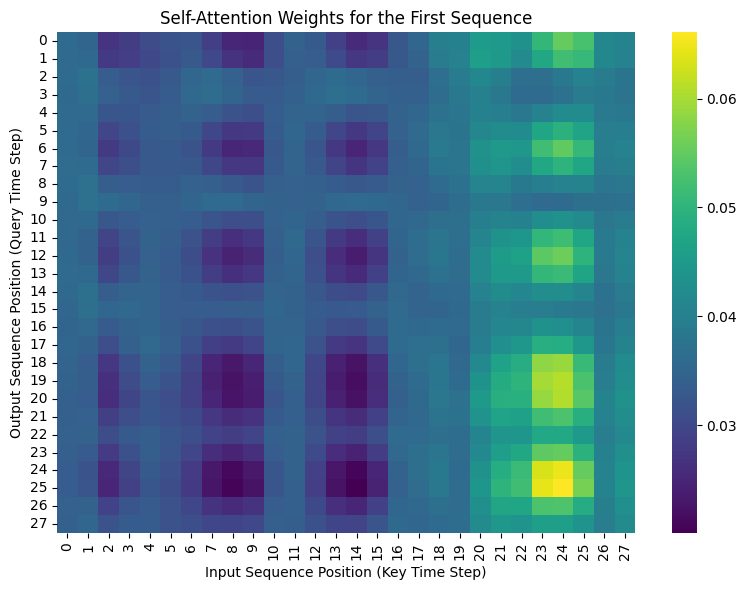

In [ ]:
# plot attention weights heatmap for one sample (for the first sequence)
plt.figure(figsize=(8,6))
sns.heatmap(att_weights[0].detach().numpy(), cmap="viridis")  # shape: (24, 24)
plt.title("Self-Attention Weights for the First Sequence")
plt.xlabel("Input Sequence Position (Key Time Step)")
plt.ylabel("Output Sequence Position (Query Time Step)")
plt.tight_layout()
plt.show()

This heatmap shows the attention weights of the first sample's self-attention layer.

- The horizontal axis represents **key time steps** (input positions being attended to).
- The vertical axis represents **query time steps** (positions generating outputs).
- Bright colors indicate stronger attention weights.

We can observe that:
- The diagonal is relatively bright, suggesting each timestep attends mostly to itself (short-term focus).
- Example 1: row 23 (query) attends more strongly to columns 20-22 (keys), indicating that the model is focusing on **recent history**, which is crucial for short-term forecasting in time series.
- Example 2: row 13 (query) shows **two distinct waves of brighter attention values** across earlier timesteps. This pattern suggests that the model may be attending to **repeating structures** in the input, potentially capturing **periodic or seasonal signals** in the sequence.

This visualization gives us insight into how the model allocates attention across the input sequence when predicting each output timestep.

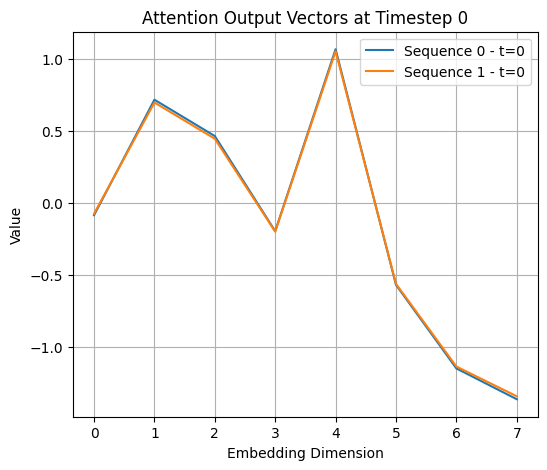

In [ ]:
# compare outputs of specific timesteps for both sequences
plt.figure(figsize=(6, 5))
plt.plot(att_output[0, 0].detach().numpy(), label="Sequence 0 - t=0")
plt.plot(att_output[1, 0].detach().numpy(), label="Sequence 1 - t=0")
plt.title("Attention Output Vectors at Timestep 0")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

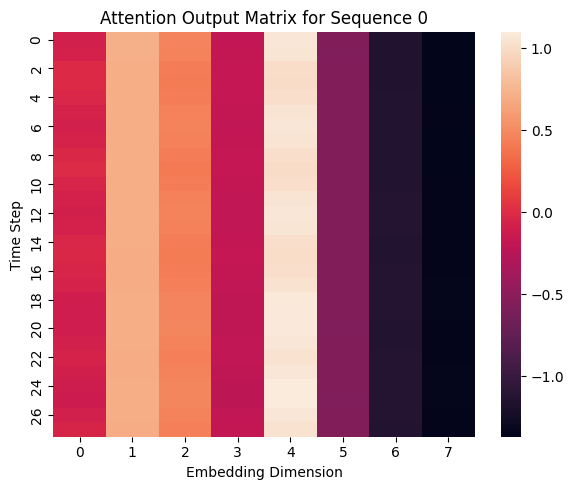

In [ ]:
# see how output values vary across time steps and embedding dimensions
plt.figure(figsize=(6, 5))
sns.heatmap(att_output[0].detach().numpy())
plt.title("Attention Output Matrix for Sequence 0")
plt.xlabel("Embedding Dimension")
plt.ylabel("Time Step")
plt.tight_layout()
plt.show()

This heatmap visualizes the attention output vectors for Sequence 0, where:
- Rows represent time steps (0 to 23),
- Columns represent embedding dimensions (0 to 7),
- Color intensity reflects the value of the output vector at each position.

General Observations:
- When an embedding dimension, for example 0 or 6, is relatively constant across time, possibly captures global or static information.
- On the other side, when an embedding dimension shows more variation, it suggests it's more sensitive to local patterns in the sequence. In our case, due to untrained weights, low embedding dimension (d_model=8), we observe very limited variation across time.
- Overall, the attention mechanism is producing structured, non-random representations that encode both global and temporal signals across the sequence.

In [ ]:
# next step of transformer-encoder (see diagram) is to add a residual connection and a Norm layer to attention outputs
print("Attention output shape before residual connection:", att_output.shape)
print("x_proj_enc shape:", x_proj_enc.shape)
# print(att_output)
att_outs_res = att_output + x_proj_enc
print("Attention output after residual connection:", att_outs_res.shape)
# print(att_outs_res)

layer_norm_1 = nn.LayerNorm(d_model)
att_outs_norm = layer_norm_1(att_outs_res)
print("Attention output after LayerNorm:", att_outs_norm.shape)
# print(att_outs_norm)

print("\nLearnable parameters of this LayerNorm layer:")
print("Total parameters:", count_trainable_params(layer_norm_1.parameters()))
for name, param in layer_norm_1.named_parameters():
  print(f"{name}: shape={param.shape}, total={param.numel()}")
  # print(param)

Attention output shape before residual connection: torch.Size([2, 28, 8])
x_proj_enc shape: torch.Size([2, 28, 8])
Attention output after residual connection: torch.Size([2, 28, 8])
Attention output after LayerNorm: torch.Size([2, 28, 8])

Learnable parameters of this LayerNorm layer:
Total parameters: 16
weight: shape=torch.Size([8]), total=8
bias: shape=torch.Size([8]), total=8


In [ ]:
# show vector for first sequence, first timestep after (res + norm)
print("First sequence, first timestep (vector after self-attention):")
print(att_outs_norm[0][0], att_outs_norm[0][0].shape)  # a vector of length d_model (8,)

First sequence, first timestep (vector after self-attention):
tensor([ 0.4327,  2.2598, -0.7259, -0.3349,  0.5246, -0.3178, -0.9412, -0.8974],
       grad_fn=<SelectBackward0>) torch.Size([8])


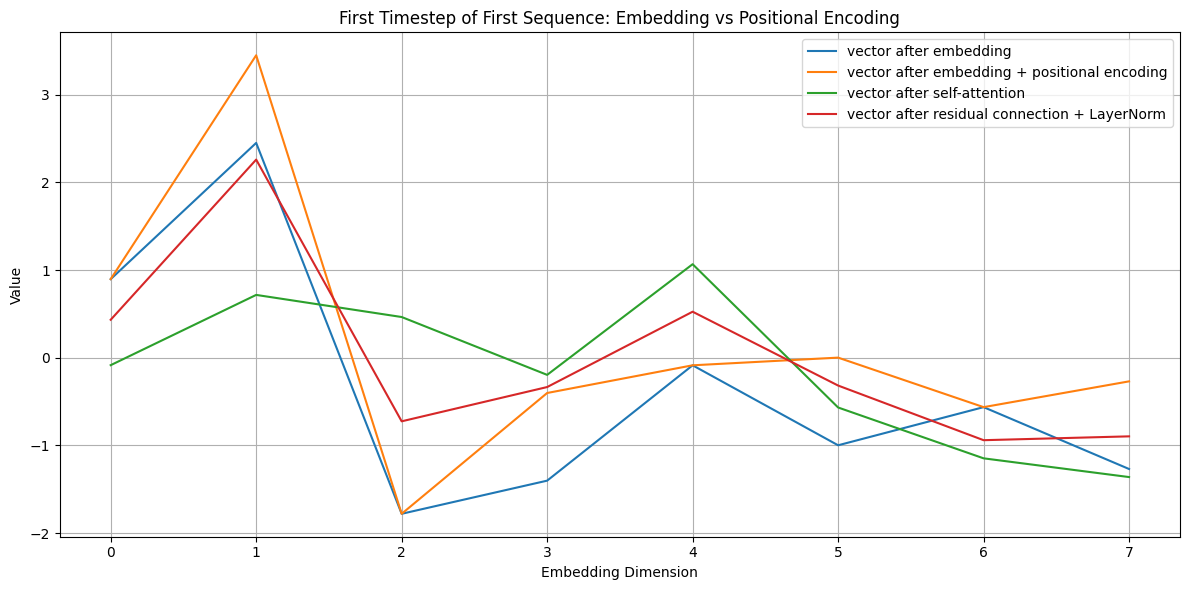

In [ ]:
# plot first sequence, first timestep after embeddings, encodings, attention head and (res+norm)
plt.figure(figsize=(12, 6))
plt.plot(x_proj_emb[0][0].detach().numpy(), label="vector after embedding")
plt.plot(x_proj_enc[0][0].detach().numpy(), label="vector after embedding + positional encoding")
plt.plot(att_output[0][0].detach().numpy(), label="vector after self-attention")
plt.plot(att_outs_norm[0][0].detach().numpy(), label="vector after residual connection + LayerNorm")
plt.title("First Timestep of First Sequence: Embedding vs Positional Encoding")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Feedforward Network (FFN) in The Transformer:

$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$

In [ ]:
# define FFN components
ffn_hidden_dim = 32  # 4 * d_model

W1 = torch.nn.Linear(d_model, ffn_hidden_dim)
W2 = torch.nn.Linear(ffn_hidden_dim, d_model)

# apply FFN to each timestep
ffn_output = W2(F.relu(W1(att_outs_norm)))
print("FFN output shape:", ffn_output.shape)  # shape: (2, 28, 8)

# additional learnable params
print("\nLearnable parameters of this FFN:")
print("W1 Weights:", W1.weight.shape)
print("W1 Biases:", W1.bias.shape)
print("W2 Weights:", W2.weight.shape)
print("W2 Biases:", W2.bias.shape)

print("Total FFN parameters:", count_trainable_params([W1.weight, W1.bias, W2.weight, W2.bias]))

FFN output shape: torch.Size([2, 28, 8])

Learnable parameters of this FFN:
W1 Weights: torch.Size([32, 8])
W1 Biases: torch.Size([32])
W2 Weights: torch.Size([8, 32])
W2 Biases: torch.Size([8])
Total FFN parameters: 552


In [ ]:
# last step: second residual connection and Norm
print("Attention output after residual+norm connection:", att_outs_norm.shape)
print("FFN output shape:", ffn_output.shape) # shape: (2, 24, 8)
ffn_output_res = ffn_output + att_outs_norm
print("Output after 2nd residual connection:", ffn_output_res.shape)

# define and apply second layer Norm
layer_norm_2 = nn.LayerNorm(d_model)
ffn_output_norm = layer_norm_2(ffn_output_res)
print("Output after 2nd LayerNorm (Final Encoder's Output):", ffn_output_norm.shape) # shape: (2, 24, 8)

print("\nLearnable parameters of this 2nd LayerNorm layer:")
print("Total parameters:", count_trainable_params(layer_norm_2.parameters()))
for name, param in layer_norm_2.named_parameters():
  print(f"{name}: shape={param.shape}, total={param.numel()}")
  # print(param)

Attention output after residual+norm connection: torch.Size([2, 28, 8])
FFN output shape: torch.Size([2, 28, 8])
Output after 2nd residual connection: torch.Size([2, 28, 8])
Output after 2nd LayerNorm (Final Encoder's Output): torch.Size([2, 28, 8])

Learnable parameters of this 2nd LayerNorm layer:
Total parameters: 16
weight: shape=torch.Size([8]), total=8
bias: shape=torch.Size([8]), total=8


In [ ]:
# show vector for first sequence, first timestep after last (res + norm)
print("First sequence, first timestep (vector after self-attention):")
print(ffn_output_norm[0][0], ffn_output_norm[0][0].shape)  # a vector of length d_model (8,)

First sequence, first timestep (vector after self-attention):
tensor([ 0.6770,  2.0316, -0.9693, -0.3458,  0.7524, -0.5263, -1.1264, -0.4932],
       grad_fn=<SelectBackward0>) torch.Size([8])


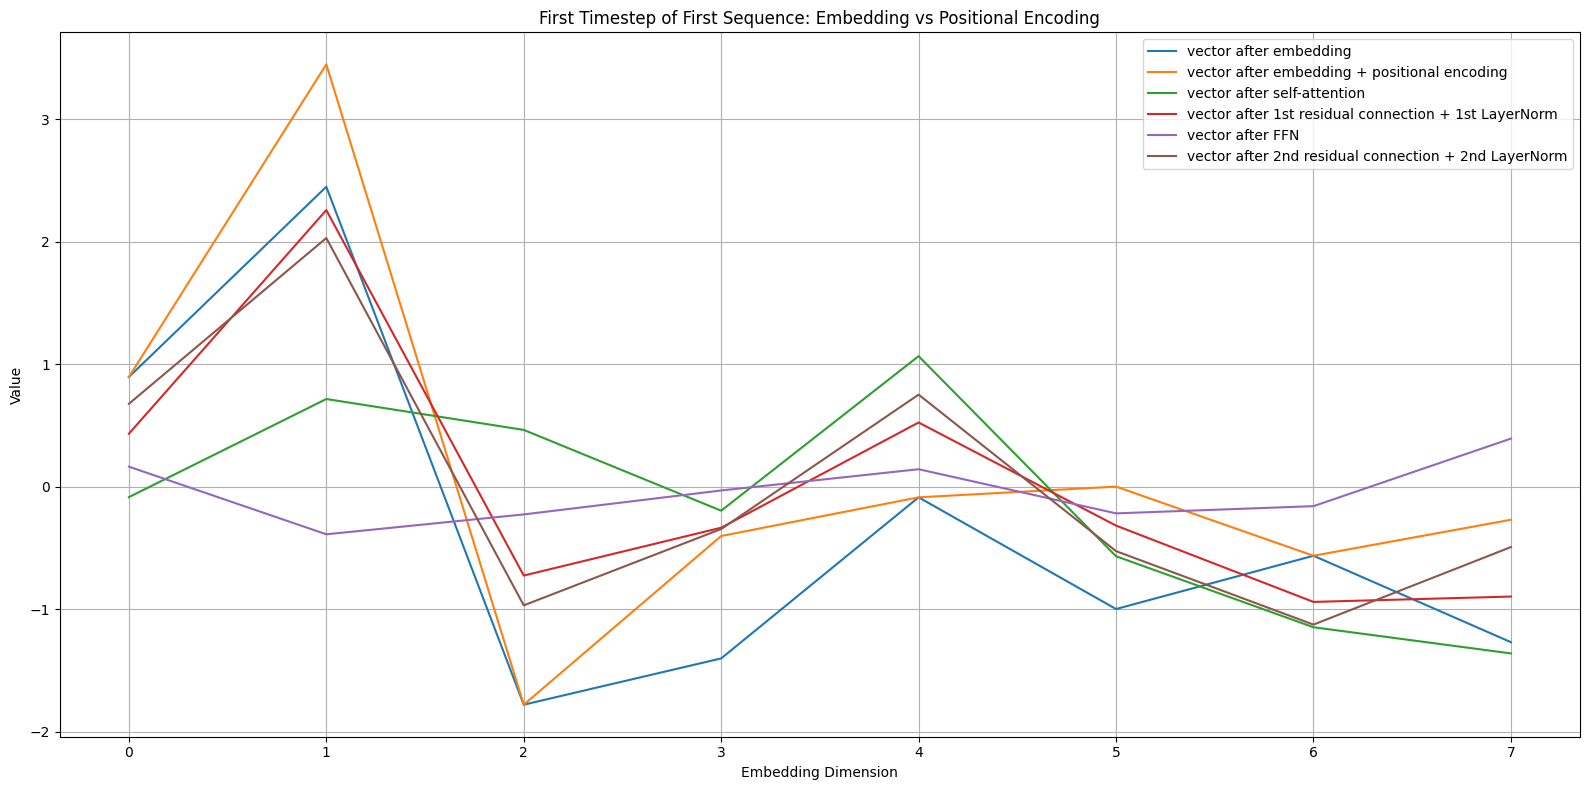

In [ ]:
# plot first sequence, first timestep after embeddings, encodings, attention head and (res+norm)
plt.figure(figsize=(16, 8))
plt.plot(x_proj_emb[0][0].detach().numpy(), label="vector after embedding")
plt.plot(x_proj_enc[0][0].detach().numpy(), label="vector after embedding + positional encoding")
plt.plot(att_output[0][0].detach().numpy(), label="vector after self-attention")
plt.plot(att_outs_norm[0][0].detach().numpy(), label="vector after 1st residual connection + 1st LayerNorm")
plt.plot(ffn_output[0][0].detach().numpy(), label="vector after FFN")
plt.plot(ffn_output_norm[0][0].detach().numpy(), label="vector after 2nd residual connection + 2nd LayerNorm")
plt.title("First Timestep of First Sequence: Embedding vs Positional Encoding")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# final encoder's output
print("Final Encoder's Output:", ffn_output_norm)
print("Final Encoder's Output shape:", ffn_output_norm.shape)

Final Encoder's Output: tensor([[[ 0.6770,  2.0316, -0.9693, -0.3458,  0.7524, -0.5263, -1.1264,
          -0.4932],
         [ 1.1004,  1.8175, -0.9821, -0.4022,  0.6803, -0.5435, -1.1563,
          -0.5140],
         [ 1.2600,  1.2054, -0.5806, -0.0484,  1.0386, -0.5125, -1.6749,
          -0.6877],
         [ 0.9971,  1.1654, -0.5236, -0.0132,  1.2806, -0.4379, -1.7315,
          -0.7370],
         [ 0.3606,  1.5729, -0.4762, -0.0958,  1.3888, -0.4419, -1.5852,
          -0.7232],
         [ 0.1176,  1.9137, -0.4424, -0.2090,  1.1871, -0.5165, -1.4166,
          -0.6339],
         [ 0.4369,  1.9942, -0.5006, -0.3439,  0.9637, -0.6048, -1.3445,
          -0.6011],
         [ 0.8764,  1.6776, -0.3568, -0.3022,  0.9721, -0.6573, -1.5409,
          -0.6689],
         [ 1.1355,  1.0673, -0.0359, -0.1333,  1.1334, -0.6149, -1.8386,
          -0.7135],
         [ 0.9309,  0.6294,  0.2646, -0.0021,  1.3841, -0.5063, -2.0017,
          -0.6987],
         [ 0.4860,  1.3732, -0.0464, -0.3705, 

To make predictions, we apply mean pooling across the encoded time steps, reducing the output from (2, 28, 8) to (2, 8). Then, a final linear layer projected the embedding to a scalar prediction for each sequence.

In [ ]:
# step 1: aggregate along the time axis (dim=1)
agg = ffn_output.mean(dim=1)
print("Aggregate output shape:", agg.shape) # shape: (2, 8)
print(agg)

Aggregate output shape: torch.Size([2, 8])
tensor([[ 0.1091, -0.3119, -0.2277,  0.0198,  0.1278, -0.1850, -0.1938,  0.4716],
        [ 0.1103, -0.3140, -0.2278,  0.0199,  0.1284, -0.1873, -0.1922,  0.4721]],
       grad_fn=<MeanBackward1>)


In [ ]:
# final 8D vectors for our 2 samples of x
print("Final 8D vectors:")
print(agg[0], agg[0].shape)
print(agg[1], agg[1].shape)

Final 8D vectors:
tensor([ 0.1091, -0.3119, -0.2277,  0.0198,  0.1278, -0.1850, -0.1938,  0.4716],
       grad_fn=<SelectBackward0>) torch.Size([8])
tensor([ 0.1103, -0.3140, -0.2278,  0.0199,  0.1284, -0.1873, -0.1922,  0.4721],
       grad_fn=<SelectBackward0>) torch.Size([8])


In [ ]:
# step 2: define output projection (scalar): from (2, 8) → (2,)
final_output_layer = nn.Linear(d_model, 1)

# additional learnable params
print("Learnable parameters of this final Linear layer:")
print("Weights:", final_output_layer.weight.shape)
print("Biases:", final_output_layer.bias.shape)
print("Total final linear layer's parameters:", count_trainable_params([final_output_layer.weight, final_output_layer.bias]))

Learnable parameters of this final Linear layer:
Weights: torch.Size([1, 8])
Biases: torch.Size([1])
Total final linear layer's parameters: 9


We can now make predictions and directly compare these predicted values to the ground truth targets.

In [ ]:
# predict y
y_pred = final_output_layer(agg).squeeze()  # shape: (2,)
print("Predicted y:", y_pred)
print("Predicted y shape:", y_pred.shape)

Predicted y: tensor([0.0968, 0.0974], grad_fn=<SqueezeBackward0>)
Predicted y shape: torch.Size([2])


In [ ]:
# compare with true values
print("True y:", y1, y2)
print("Predicted y:", y_pred[0].detach(), y_pred[1].detach())

True y: tensor(-1.3528) tensor(-0.9861)
Predicted y: tensor(0.0968) tensor(0.0974)


This completes the full Transformer encoder forward process, step by step, from raw input to final scalar prediction. Since all weights are randomly initialized, the predictions are meaningless at this point. To produce accurate forecasts, we need to **train the model** and **optimize all learnable parameters**.

In [ ]:
# total trainable params
total_params = [
    pos_emb.weight, pos_emb.bias, # embedding params
    W_q.weight, W_q.bias, # attention Q params
    W_k.weight, W_k.bias, # attention K params
    W_v.weight, W_v.bias, # attention V params
    layer_norm_1.weight, layer_norm_1.bias, # 1st layer norm params
    W1.weight, W1.bias, # FFN W1 params
    W2.weight, W2.bias, # FFN W2 params
    layer_norm_2.weight, layer_norm_2.bias, # 2nd layer norm params
    final_output_layer.weight, final_output_layer.bias # final linear layer params
]

print("Total trainable parameters of this dummy transformer-encoder:", sum(param.numel() for param in total_params))

Total trainable parameters of this dummy transformer-encoder: 825


In the self-attention mechanism, each timestep in the sequence is represented by a vector of dimension `d_model = 8`. When using a **single attention head**, the model compares each 8D vector (e.g. timestep 5) with all other 8D vectors in the sequence by computing dot products between Query and Key vectors. These comparisons determine how much each timestep should contribute (via the Value vectors) to the output at that position.

When we use `num_heads = 2`, we don't split the 8D input vector into parts and assign one to each head. Instead, **each head sees the full 8D vector** at every timestep and applies its **own learned Q, K, V projections**, which map the input to a smaller internal dimension (e.g. 4D if `head_dim = 4`). Each head then computes attention **independently**, producing an output of shape `(seq_len, 4)`. These outputs are then **concatenated** to give a final result of shape `(seq_len, 8)`, preserving the original embedding size.

Think of each attention head as a different expert that looks at the same input sequence, but **focuses on different patterns or relationships** within it. By combining their perspectives, the model builds a richer, more informative representation of the sequence.

In [ ]:
# multi head attention setup (2 heads)
num_heads = 2
head_dim = d_model // num_heads  # 8 // 2 = 4 (rounded)

# step 1: create Q, K and V projections for each head
W_q_heads = [nn.Linear(d_model, head_dim) for _ in range(num_heads)]
W_k_heads = [nn.Linear(d_model, head_dim) for _ in range(num_heads)]
W_v_heads = [nn.Linear(d_model, head_dim) for _ in range(num_heads)]

In [ ]:
# Print the structure of W_q for each head
for i, W_q in enumerate(W_q_heads):
  print(f"Head {i}: W_q weight shape = {W_q.weight.shape}, bias shape = {W_q.bias.shape}")

Head 0: W_q weight shape = torch.Size([4, 8]), bias shape = torch.Size([4])
Head 1: W_q weight shape = torch.Size([4, 8]), bias shape = torch.Size([4])


In [ ]:
# step 2: run attention for each head
head_outputs = []
head_weights = []

for i in range(num_heads):
  out, weights = batch_custom_attention_head(x_proj_enc, W_q_heads[i], W_k_heads[i], W_v_heads[i], head_dim)

  head_outputs.append(out)  # shape: (batch_size, seq_len, head_dim) (2, 24, 4)
  head_weights.append(weights)  # shape: (batch_size, seq_len, seq_len) (2, 24, 24)

In [ ]:
# some intuitive prints
print("Number of computed attention heads:", len(head_outputs))
print("1st Head outputs shape:", head_outputs[0].shape)  # (2, 28, 4)
print("1st Head weights shape:", head_weights[0].shape)  # (2, 28, 24)

print("\nFirst head, first sequence (vector after self-attention):")
print(head_outputs[0][0], head_outputs[0][0].shape)  # (28, 8)

print("\nFirst head, first sequence, first vector (row):")
print(head_outputs[0][0][0], head_outputs[0][0][0].shape)  # (4,)

Number of computed attention heads: 2
1st Head outputs shape: torch.Size([2, 28, 4])
1st Head weights shape: torch.Size([2, 28, 28])

First head, first sequence (vector after self-attention):
tensor([[-0.2244, -0.0645,  0.1152,  0.3757],
        [-0.2303, -0.0639,  0.1091,  0.3645],
        [-0.2254, -0.0578,  0.1176,  0.3958],
        [-0.2107, -0.0473,  0.1157,  0.4172],
        [-0.2036, -0.0466,  0.1189,  0.4251],
        [-0.2105, -0.0565,  0.1242,  0.4119],
        [-0.2250, -0.0674,  0.1241,  0.3856],
        [-0.2357, -0.0715,  0.1244,  0.3758],
        [-0.2326, -0.0648,  0.1242,  0.3913],
        [-0.2187, -0.0535,  0.1237,  0.4175],
        [-0.2065, -0.0466,  0.1162,  0.4186],
        [-0.2088, -0.0531,  0.1189,  0.4085],
        [-0.2231, -0.0657,  0.1242,  0.3891],
        [-0.2369, -0.0729,  0.1268,  0.3765],
        [-0.2375, -0.0683,  0.1254,  0.3842],
        [-0.2241, -0.0551,  0.1179,  0.4012],
        [-0.2095, -0.0454,  0.1111,  0.4107],
        [-0.2081, -0.0492,

In [ ]:
# step 3: concatenate outputs along the embedding dimension (dim=-1) -> shape: (2, 24, d_model)
multihead_output = torch.cat(head_outputs, dim=-1)
print("Multi-head attention output shape:", multihead_output.shape) # (2, 28, 8)
# print(multihead_output)

Multi-head attention output shape: torch.Size([2, 28, 8])


After the multi-head attention block (with concat), everything that follows like residuals, normalizations, FFN and output stays exactly the same.

### Custom Transformer-Encoder

In [ ]:
# complete trransformer-encoder function based on all above steps
def transformer_encoder(X, d_model, num_heads=2, ffn_dim=32):
  """
  Full custom Transformer encoder forward pass.

  Args:
      X: input tensor of shape (N, L), L is seq_len
      d_model: embedding size
      num_heads: number of attention heads
      ffn_dim: hidden layer size of feedforward network

  Returns:
      y_pred: predictions of shape (N,)
  """
  N, L = X.shape
  x = X.unsqueeze(-1)  # (N, L, 1)

  # step 1: input projection (add embeddings)
  input_proj = nn.Linear(1, d_model) # use nn.Linear in this case
  x_proj = input_proj(x)  # shape: (N, L, d_model)

  # step 2: positional encoding
  pos_enc = get_positional_encoding(L, d_model)  # shape: (L, d_model)
  pos_enc = pos_enc.unsqueeze(0)  # shape: (1, L, d_model)
  x_proj_enc = x_proj + pos_enc  # shape: (N, L, d_model)

  # step 3: (multi) head atatention
  head_dim = d_model // num_heads
  W_q_heads = [nn.Linear(d_model, head_dim) for _ in range(num_heads)]
  W_k_heads = [nn.Linear(d_model, head_dim) for _ in range(num_heads)]
  W_v_heads = [nn.Linear(d_model, head_dim) for _ in range(num_heads)]

  head_outputs = []
  head_weights = []

  for i in range(num_heads):
    out, weights = batch_custom_attention_head(x_proj_enc, W_q_heads[i], W_k_heads[i], W_v_heads[i], head_dim)
    head_outputs.append(out)  # shape: (N, L, head_dim) (batch_size, seq_len, head_dim)
    head_weights.append(weights)  # shape: (N, L, L) (batch_size, seq_len, seq_len)

  multihead_output = torch.cat(head_outputs, dim=-1)  # shape: (N, L, d_model)

  # step 4: add residual connection + layer norm
  att_out_res = multihead_output + x_proj_enc # shape: (N, L, d_model)

  layer_norm_1 = nn.LayerNorm(d_model)
  att_out_norm = layer_norm_1(att_out_res)  # shape: (N, L, d_model)

  # step 5: feedforward network
  W1 = torch.nn.Linear(d_model, ffn_dim)
  W2 = torch.nn.Linear(ffn_dim, d_model)
  ffn_output = W2(F.relu(W1(att_out_norm)))  # shape: (N, L, d_model)

  # step 6: add 2nd residual connection + layer norm
  ffn_output_res = ffn_output + att_out_norm  # shape: (N, L, d_model)

  layer_norm_2 = nn.LayerNorm(d_model)
  ffn_output_norm = layer_norm_2(ffn_output_res)  # shape: (N, L, d_model)

  # step 7: aggreagation (mean over time) and output projection
  agg = ffn_output_norm.mean(dim=1)  # shape: (N, d_model)

  output_layer = nn.Linear(d_model, 1)
  y_pred = output_layer(agg).squeeze()  # shape: (N,)

  return y_pred

In [ ]:
# convert and work with model-classes for easier handling of both custom and modular transformer-encoders
class CustomTransformerEncoder(nn.Module):
  """
  Custom Transformer encoder module.

  Args:
      seq_len: sequence length
      d_model: embedding size
      num_heads: number of attention heads
      ffn_dim: hidden layer size of feedforward network

  Returns:
      y_pred: predictions of shape (N,)
  """
  def __init__(self, seq_len, d_model=16, num_heads=2, ffn_dim=32):
    super().__init__()
    self.seq_len = seq_len
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads

    # input projection
    self.input_proj = nn.Linear(1, d_model)

    # positional encoding (fixed, not trainable)
    self.pos_enc = get_positional_encoding(seq_len, d_model).unsqueeze(0)
    # self.register_buffer("pos_enc", get_positional_encoding(seq_len, d_model).unsqueeze(0))

    # learnable projection layers per head
    self.W_q_heads = nn.ModuleList([nn.Linear(d_model, self.head_dim) for _ in range(num_heads)])
    self.W_k_heads = nn.ModuleList([nn.Linear(d_model, self.head_dim) for _ in range(num_heads)])
    self.W_v_heads = nn.ModuleList([nn.Linear(d_model, self.head_dim) for _ in range(num_heads)])

    # norm layers
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)

    # ffn layers
    self.ffn1 = nn.Linear(d_model, ffn_dim)
    self.ffn2 = nn.Linear(ffn_dim, d_model)

    # output layer
    self.output_layer = nn.Linear(d_model, 1)

  def forward(self, x):
    # x = x.to(device)
    x = x.to(self.input_proj.weight.device)

    if x.dim() == 2:  # (N, L) -> (N, L, 1)
      x = x.unsqueeze(-1)

    # projection + positiona encodings
    x_proj = self.input_proj(x)  # (N, L, d_model)
    # x_proj_enc = x_proj + self.pos_enc # (N, L, d_model)
    x_proj_enc = x_proj + self.pos_enc.to(x_proj.device)

    # multi-head attention
    head_outputs = []
    for i in range(self.num_heads):
      out, _ = batch_custom_attention_head(x_proj_enc, self.W_q_heads[i], self.W_k_heads[i], self.W_v_heads[i], self.head_dim)
      head_outputs.append(out)

    att_out = torch.cat(head_outputs, dim=-1)  # (N, L, d_model)

    # residual connections and normalization
    att_out = self.norm1(att_out + x_proj_enc)

    # feedforward pass, 2nd residual connection ansd normalization
    ffn_output = self.ffn2(F.relu(self.ffn1(att_out)))
    ffn_output = self.norm2(ffn_output + att_out)

    # aggregate and predict
    agg = ffn_output.mean(dim=1)
    y_pred = self.output_layer(agg).squeeze(-1) # (N,1) -> (N,)

    return y_pred

In [ ]:
def train_transformer_encoder(model, train_loader, val_loader, epochs=100, lr=1e-3, weight_decay=1e-4, patience=10, verbose_every=10):
  """
  Trains a Transformer encoder (custom or modular).

  Args:
    - model: Transformer encoder nn.Module (custom or modular)
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - epochs: int, number of training epochs
    - batch_size: int, batch size
    - lr: float, learning rate
    - weight_decay: float, weight decay
    - patience: int, early stopping patience
    - verbose_every: int, print progress every n epochs

  Returns:
    - history: dict with train/val losses & R² per epoch, plus:
        'params' -> best state_dict
        'model' -> model with best weights loaded
        'total_training_time'
        'total_params'
        'best_val_loss'
        'stopped_epoch'
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # set optimizer and loss function
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  loss_fn = nn.MSELoss()

  history = {'train_loss': [], 'val_loss': [], 'train_r2': [], 'val_r2': [] }

  best_val_loss = float("inf")
  best_state = {k: v.clone() for k, v in model.state_dict().items()}
  no_improve = 0
  stopped_epoch = epochs

  # train step
  start_time = time.time()
  model.train()
  for epoch in range(epochs):

    train_preds, train_targets = [], []
    total_loss = 0.0

    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      # print(X_batch.shape, y_batch.shape) # (batch_size, seq_len, input_size), e.g. (32, 48, 1) and (batch_size, 1), e.g. (32, 1)

      y_pred = model(X_batch)
      y_pred = y_pred.squeeze(-1) # (batch_size, seq_len)
      y_batch = y_batch.squeeze(-1) # (batch_size,)
      # print(y_pred.shape, y_batch.shape)
      loss = loss_fn(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
      optimizer.step()

      total_loss += loss.item()

      train_preds.extend(y_pred.detach().cpu().numpy())
      train_targets.extend(y_batch.detach().cpu().numpy())

    avg_train_loss = total_loss / max(1, len(train_loader))
    train_r2 = r2_fn(train_targets, train_preds)

    # validation step
    model.eval()
    val_preds, val_targets = [], []
    val_total_loss = 0.0

    with torch.no_grad():
      for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        if X_batch.dim() == 2:
          X_batch = X_batch.unsqueeze(-1)

        y_pred = model(X_batch)
        y_pred = y_pred.squeeze(-1)  # (B, 1) -> (B,)
        y_batch = y_batch.squeeze(-1)  # (B,)

        loss = loss_fn(y_pred, y_batch)
        val_total_loss += loss.item()

        val_preds.extend(y_pred.cpu().numpy())
        val_targets.extend(y_batch.cpu().numpy())

    avg_val_loss = val_total_loss / max(1, len(val_loader))
    val_r2 = r2_fn(val_targets, val_preds)

    # log metrics
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_r2'].append(train_r2)
    history['val_r2'].append(val_r2)

    if (epoch + 1) % verbose_every == 0:
      print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, R²: {train_r2:.4f} | Val Loss: {avg_val_loss:.4f}, R²: {val_r2:.4f}")

    # early stopping (min val loss)
    if avg_val_loss < best_val_loss - 1e-8:
      best_val_loss = avg_val_loss
      best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
      no_improve = 0
    else:
      no_improve += 1
      if no_improve >= patience:
        stopped_epoch = epoch
        break

  total_time = time.time() - start_time
  total_params = count_trainable_params(model.parameters())

  print(f"\nTotal training time: {total_time:.2f} seconds")
  print(f"Total trainable parameters: {total_params}")

  # restore best weights
  model.load_state_dict(best_state)

  history.update({
      "params": best_state, # best model state_dict
      "model": model, # model with best weights loaded
      "total_training_time": round(total_time, 4),
      "total_params": total_params,
      "best_val_loss": float(best_val_loss),
      "stopped_epoch": stopped_epoch,
    })

  return history

In [ ]:
# ensure using gpu, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# set d_model
d_model = 16

# initialize models
custom_enc1h = CustomTransformerEncoder(seq_len=hour_window_size, d_model=d_model).to(device)

custom_enc6h = CustomTransformerEncoder(seq_len=six_window_size, d_model=d_model).to(device)

custom_enc24h = CustomTransformerEncoder(seq_len=day_window_size, d_model=d_model).to(device)

In [ ]:
print("Training custom Transformer-Encoder for 1H resolution")
custom_enc1h_history = train_transformer_encoder(custom_enc1h, hour_train_loader, hour_val_loader)

print("\nTraining custom Transformer-Encoder for 6H resolution")
custom_enc6h_history = train_transformer_encoder(custom_enc6h, six_train_loader, six_val_loader)

print("\nTraining custom Transformer-Encoder for 24H resolution")
custom_enc24h_history = train_transformer_encoder(custom_enc24h, day_train_loader, day_val_loader)

Training custom Transformer-Encoder for 1H resolution
Epoch 10/100, Train Loss: 0.0141, R²: 0.9857 | Val Loss: 0.0300, R²: 0.9708
Epoch 20/100, Train Loss: 0.0121, R²: 0.9878 | Val Loss: 0.0280, R²: 0.9727
Epoch 30/100, Train Loss: 0.0114, R²: 0.9885 | Val Loss: 0.0269, R²: 0.9736
Epoch 40/100, Train Loss: 0.0109, R²: 0.9889 | Val Loss: 0.0252, R²: 0.9749
Epoch 50/100, Train Loss: 0.0106, R²: 0.9892 | Val Loss: 0.0238, R²: 0.9761
Epoch 60/100, Train Loss: 0.0105, R²: 0.9894 | Val Loss: 0.0231, R²: 0.9768
Epoch 70/100, Train Loss: 0.0104, R²: 0.9895 | Val Loss: 0.0227, R²: 0.9773
Epoch 80/100, Train Loss: 0.0103, R²: 0.9895 | Val Loss: 0.0224, R²: 0.9775
Epoch 90/100, Train Loss: 0.0102, R²: 0.9896 | Val Loss: 0.0223, R²: 0.9777
Epoch 100/100, Train Loss: 0.0102, R²: 0.9897 | Val Loss: 0.0221, R²: 0.9778

Total training time: 112.74 seconds
Total trainable parameters: 2001

Training custom Transformer-Encoder for 6H resolution
Epoch 10/100, Train Loss: 0.3641, R²: 0.6258 | Val Loss: 0.7

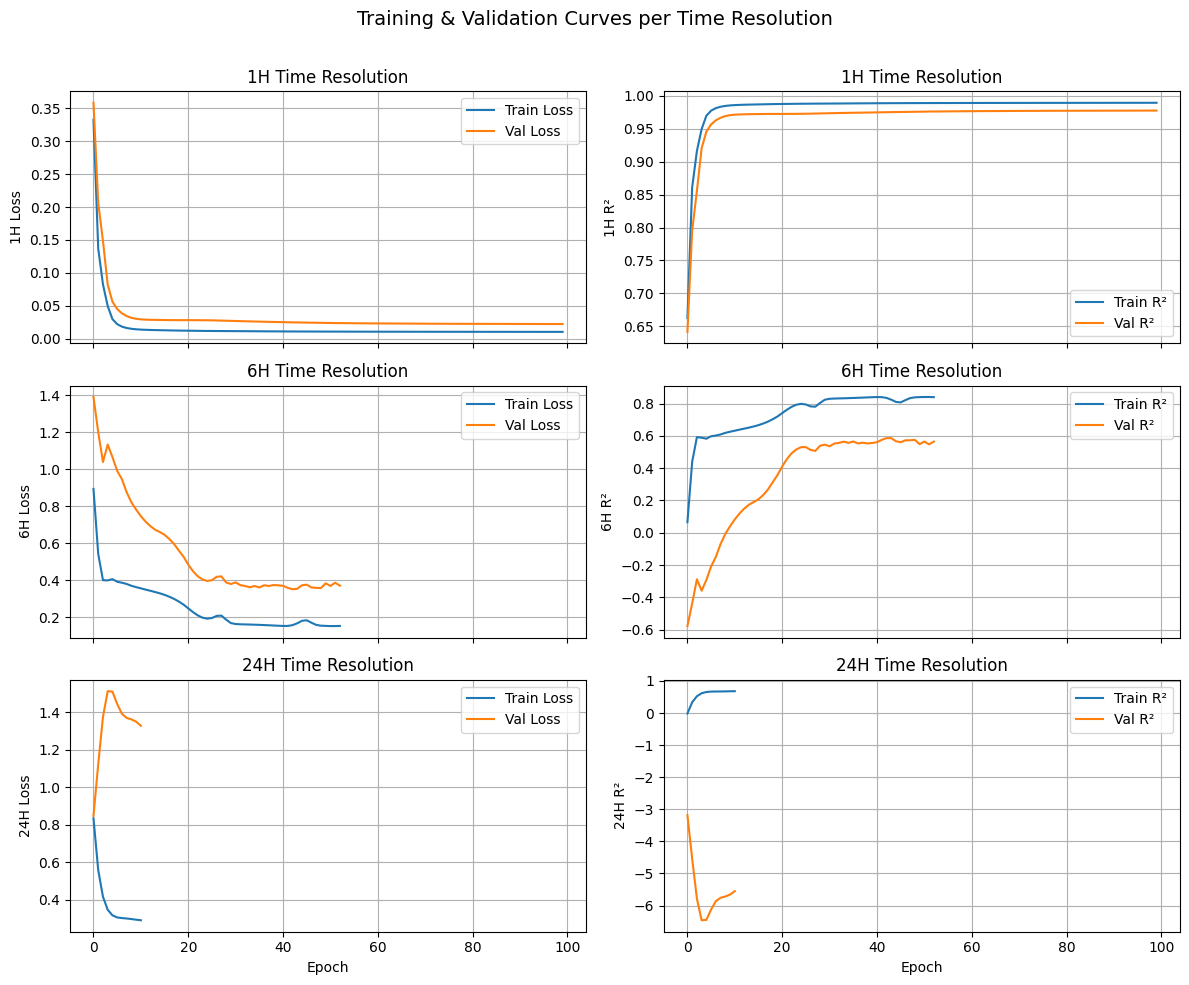

In [ ]:
# plot all learning curves
plot_learning_curves_all([custom_enc1h_history, custom_enc6h_history, custom_enc24h_history], ["1H", "6H", "24H"])

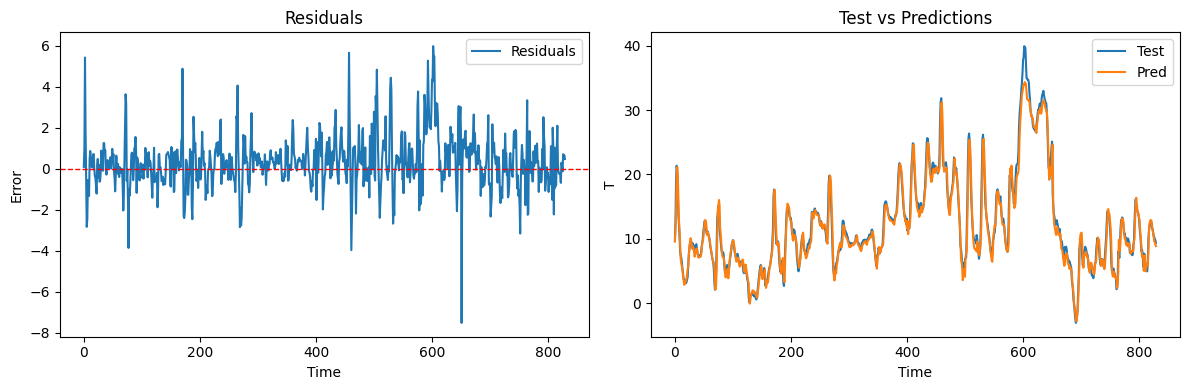


1H series (1 steps-ahead forecasts)
1H Custom Transformer-Encoder Training Time: 112.7433
1H Custom Transformer-Encoder: MAE=0.92, MSE=1.31, MAPE=10.79


In [ ]:
# 1H 1-step ahead preds
custom_enc1h_preds_norm, custom_enc1h_trues_norm, _, _ = predict_nn_mod(custom_enc1h_history["model"], hour_test_loader)

# denormalize, plot and evaluate
custom_enc1h_preds = denormalize(custom_enc1h_preds_norm, hour_mean, hour_std)
custom_enc1h_trues = denormalize(custom_enc1h_trues_norm, hour_mean, hour_std)
plot_residuals_preds(custom_enc1h_trues, custom_enc1h_preds, "1H")
ce_mae1, ce_rmse1, ce_mape1 = evaluate_model(custom_enc1h_trues, custom_enc1h_preds)

print("\n1H series (1 steps-ahead forecasts)")
print(f"1H Custom Transformer-Encoder Training Time: {custom_enc1h_history['total_training_time']}")
print(f"1H Custom Transformer-Encoder: MAE={ce_mae1}, MSE={ce_rmse1}, MAPE={ce_mape1}")

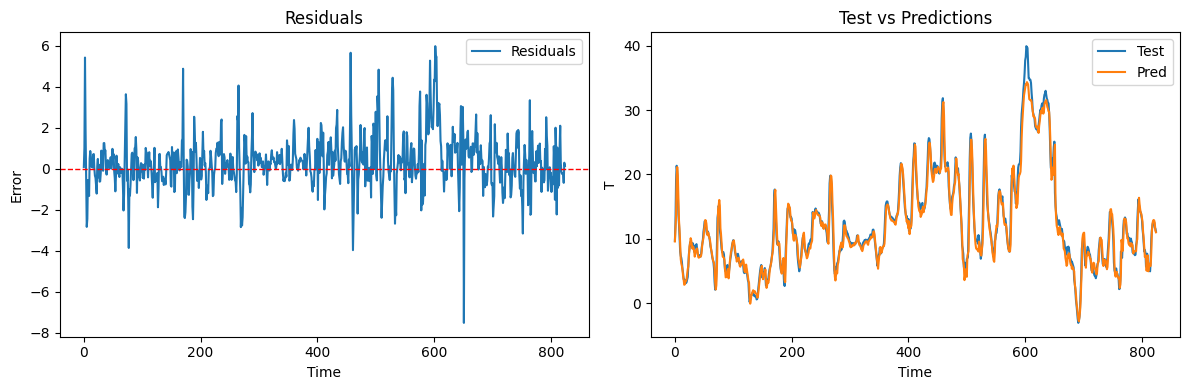


1H series (6 steps-ahead forecasts)
1H Custom Transformer-Encoder: MAE=0.92, MSE=1.32, MAPE=10.82


In [ ]:
# 1H 6-step ahead preds (we use test dataloader whose targets are the next 6 values per sample)
custom_enc16h_preds_norm, custom_enc16h_trues_norm, _, _ = predict_nn_mod(custom_enc1h_history["model"], hour6_test_loader)

# denormalize, plot and evaluate
custom_enc16h_preds = denormalize(custom_enc16h_preds_norm, hour_mean, hour_std)
custom_enc16h_trues = denormalize(custom_enc16h_trues_norm, hour_mean, hour_std)
plot_residuals_preds(custom_enc16h_trues, custom_enc16h_preds, "1H")
ce_mae16, ce_rmse16, ce_mape16 = evaluate_model(custom_enc16h_trues, custom_enc16h_preds)

print("\n1H series (6 steps-ahead forecasts)")
print(f"1H Custom Transformer-Encoder: MAE={ce_mae16}, MSE={ce_rmse16}, MAPE={ce_mape16}")

In [ ]:
# see some examples of preds with its corresponding true values
print(custom_enc1h_preds[0], custom_enc1h_trues[0])
print(custom_enc16h_preds[5], custom_enc16h_trues[5])

9.582776912870848 9.66671089251817
19.87962518043164 17.045765889441146


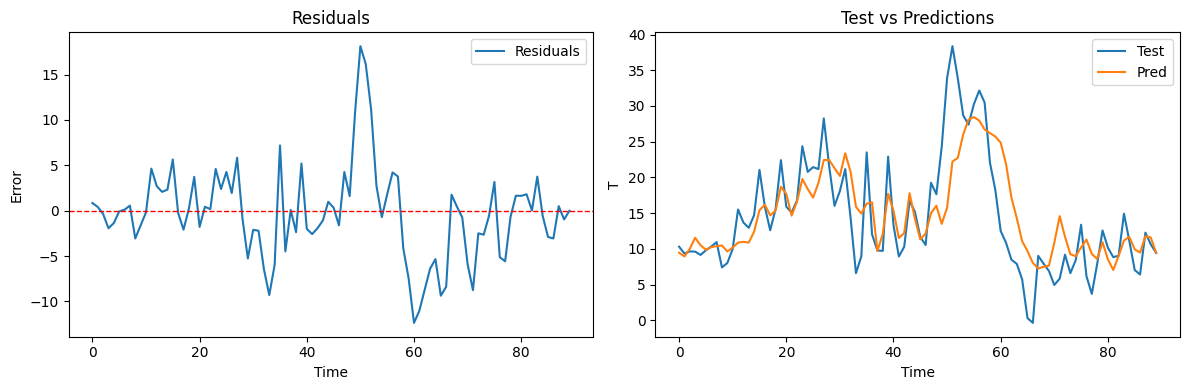


6H series (1 steps-ahead forecasts)
6H Custom Transformer-Encoder Training Time: 9.622
6H Custom Transformer-Encoder: MAE=3.57, MSE=5.06, MAPE=88.13


In [ ]:
# 6H 1-step ahead preds
custom_enc6h_preds_norm, custom_enc6h_trues_norm, _, _ = predict_nn_mod(custom_enc6h_history["model"], six_test_loader)

# denormalize, plot and evaluate
custom_enc6h_preds = denormalize(custom_enc6h_preds_norm, six_mean, six_std)
custom_enc6h_trues = denormalize(custom_enc6h_trues_norm, six_mean, six_std)
plot_residuals_preds(custom_enc6h_trues, custom_enc6h_preds, "6H")
ce_mae6, ce_rmse6, ce_mape6 = evaluate_model(custom_enc6h_trues, custom_enc6h_preds)

print("\n6H series (1 steps-ahead forecasts)")
print(f"6H Custom Transformer-Encoder Training Time: {custom_enc6h_history['total_training_time']}")
print(f"6H Custom Transformer-Encoder: MAE={ce_mae6}, MSE={ce_rmse6}, MAPE={ce_mape6}")

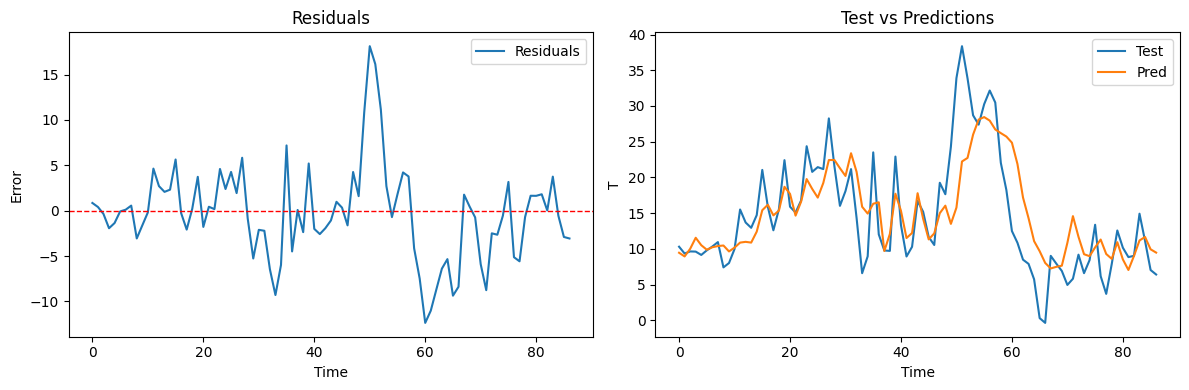


6H series (4 steps-ahead forecasts)
6H Custom Transformer-Encoder: MAE=3.67, MSE=5.15, MAPE=91.02


In [ ]:
# 6H 4-step ahead preds (we use test dataloader whose targets are the next 4 values per sample)
custom_enc64h_preds_norm, custom_enc6h4_trues_norm, _, _ = predict_nn_mod(custom_enc6h_history["model"], six4_test_loader)

# denormalize, plot and evaluate
custom_enc64h_preds = denormalize(custom_enc64h_preds_norm, six_mean, six_std)
custom_enc64h_trues = denormalize(custom_enc6h4_trues_norm, six_mean, six_std)
plot_residuals_preds(custom_enc64h_trues, custom_enc64h_preds, "6H")
ce_mae64, ce_rmse64, ce_mape64 = evaluate_model(custom_enc64h_trues, custom_enc64h_preds)

print("\n6H series (4 steps-ahead forecasts)")
print(f"6H Custom Transformer-Encoder: MAE={ce_mae64}, MSE={ce_rmse64}, MAPE={ce_mape64}")

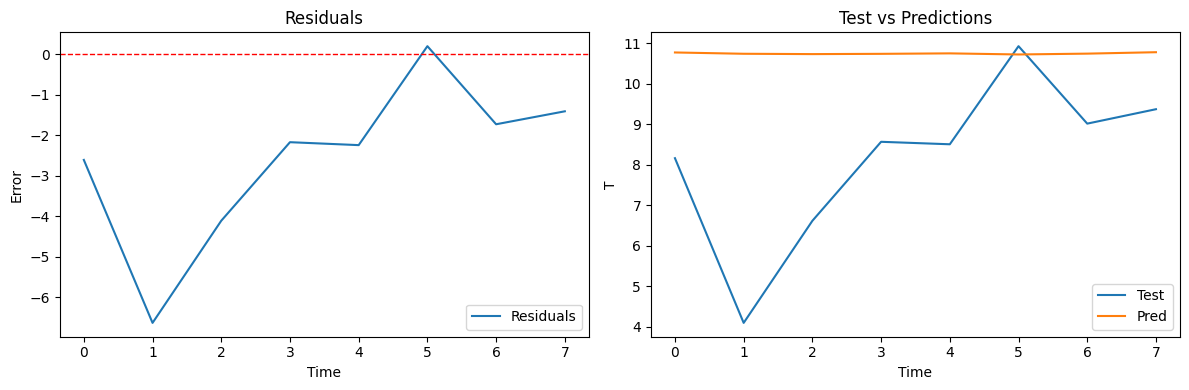


24H series (1 steps-ahead forecasts)
24H Custom Transformer-Encoder Training Time: 0.5061
24H Custom Transformer-Encoder: MAE=2.64, MSE=3.21, MAPE=42.97


In [ ]:
# 24H 1-step ahead preds
custom_enc24h_preds_norm, custom_enc24h_trues_norm, _, _ = predict_nn_mod(custom_enc24h_history["model"], day_test_loader)

# denormalize, plot and evaluate
custom_enc24h_preds = denormalize(custom_enc24h_preds_norm, day_mean, day_std)
custom_enc24h_trues = denormalize(custom_enc24h_trues_norm, day_mean, day_std)
plot_residuals_preds(custom_enc24h_trues, custom_enc24h_preds, "24H")
ce_mae24, ce_rmse24, ce_mape24 = evaluate_model(custom_enc24h_trues, custom_enc24h_preds)

print("\n24H series (1 steps-ahead forecasts)")
print(f"24H Custom Transformer-Encoder Training Time: {custom_enc24h_history['total_training_time']}")
print(f"24H Custom Transformer-Encoder: MAE={ce_mae24}, MSE={ce_rmse24}, MAPE={ce_mape24}")

In [ ]:
enc_results = [
    ("Custom Transformer-Encoder", "1-hour", "t+1", "T_mean", "Univariate", ce_mae1, ce_rmse1, ce_mape1, custom_enc1h_history['total_training_time'], custom_enc1h_history['total_params']),
    ("Custom Transformer-Encoder", "1-hour", "t+6", "T_mean", "Univariate", ce_mae16, ce_rmse16, ce_mape16, custom_enc1h_history['total_training_time'], custom_enc1h_history['total_params']),
    ("Custom Transformer-Encoder", "6-hour", "t+1", "T_mean", "Univariate", ce_mae6, ce_rmse6, ce_mape6, custom_enc6h_history['total_training_time'], custom_enc6h_history['total_params']),
    ("Custom Transformer-Encoder", "6-hour", "t+4", "T_mean", "Univariate", ce_mae64, ce_rmse64, ce_mape64, custom_enc6h_history['total_training_time'], custom_enc6h_history['total_params']),
    ("Custom Transformer-Encoder", "24-hour", "t+1", "T_mean", "Univariate", ce_mae24, ce_rmse24, ce_mape24, custom_enc24h_history['total_training_time'], custom_enc24h_history['total_params'])
]

In [ ]:
# print results
print(tabulate(enc_results, headers=columns, tablefmt="github", floatfmt=".2f"))

| Model                      | Resolution   | Horizon   | Target Variable   | Input Type   |   MAE |   RMSE |   MAPE (%) |   Fit Time |   # Params |
|----------------------------|--------------|-----------|-------------------|--------------|-------|--------|------------|------------|------------|
| Custom Transformer-Encoder | 1-hour       | t+1       | T_mean            | Univariate   |  0.92 |   1.31 |      10.79 |     112.74 |       2001 |
| Custom Transformer-Encoder | 1-hour       | t+6       | T_mean            | Univariate   |  0.92 |   1.32 |      10.82 |     112.74 |       2001 |
| Custom Transformer-Encoder | 6-hour       | t+1       | T_mean            | Univariate   |  3.57 |   5.06 |      88.13 |       9.62 |       2001 |
| Custom Transformer-Encoder | 6-hour       | t+4       | T_mean            | Univariate   |  3.67 |   5.15 |      91.02 |       9.62 |       2001 |
| Custom Transformer-Encoder | 24-hour      | t+1       | T_mean            | Univariate   |  2.64 |   3.2

### Pytorch Transformer-Encoder

The PyTorch modular version simplifies the architecture by using `nn.TransformerEncoderLayer`, which internally handles multi-head attention, residuals, normalization, and feedforward layers. This reduces complexity compared to the custom implementation, where all components are manually defined. Positional encoding remains manually added in both, but can be made trainable if needed.

In [ ]:
# transformer-encoder model using PyTorch modules
class ModularTransformerEncoder(nn.Module):
  """
  Modular Transformer encoder module.
  """
  def __init__(self, seq_len, d_model=16, num_heads=2, ffn_dim=32):
    super().__init__()
    self.seq_len = seq_len
    self.d_model = d_model

    # project scalar input (1 feature per time step) to d_model
    self.input_proj = nn.Linear(1, d_model)

    # positional encoding (fixed, not trainable)
    pe = get_positional_encoding(seq_len, d_model)  # (L, d_model)
    self.register_buffer("pos_enc", pe.unsqueeze(0))  # (1, L, d_model)

    # transformer-encoder layer
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=d_model,
        nhead=num_heads,
        dim_feedforward=ffn_dim,
        batch_first=True  # keeps input as (N, L, D)
        )
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

    # output projection
    self.output_layer = nn.Linear(d_model, 1)

  def forward(self, x):
    # x: (N, L), but accept (N, L) or (N, L, 1)
    if x.dim() == 2:  # (N, L) -> (N, L, 1)
      x = x.unsqueeze(-1)  # (N, L, 1)
    x_proj = self.input_proj(x)  # (N, L, d_model)

    # add positional encoding
    x_proj = x_proj + self.pos_enc  # (N, L, d_model)
    # x_proj += self.pos_enc[:, :x_proj.size(1), :]

    # transformer encoding
    enc_out = self.encoder(x_proj)  # (N, L, d_model)

    # aggregate and predict
    agg = enc_out.mean(dim=1)  # (N, d_model)
    y_pred = self.output_layer(agg).squeeze()  # (N,)

    return y_pred

In [ ]:
# initialize modular models
mod_enc1h = ModularTransformerEncoder(seq_len=hour_window_size, d_model=d_model).to(device)

mod_enc6h = ModularTransformerEncoder(seq_len=six_window_size, d_model=d_model).to(device)

mod_enc24h = ModularTransformerEncoder(seq_len=day_window_size, d_model=d_model).to(device)

In [ ]:
print("Training modular Transformer-Encoder for 1H resolution")
mod_enc1h_history = train_transformer_encoder(mod_enc1h, hour_train_loader, hour_val_loader)

print("\nTraining modular Transformer-Encoder for 6H resolution")
mod_enc6h_history = train_transformer_encoder(mod_enc6h, six_train_loader, six_val_loader)

print("\nTraining modular Transformer-Encoder for 24H resolution")
mod_enc24h_history = train_transformer_encoder(mod_enc24h, day_train_loader, day_val_loader)

Training modular Transformer-Encoder for 1H resolution
Epoch 10/100, Train Loss: 0.0152, R²: 0.9846 | Val Loss: 0.0298, R²: 0.9707
Epoch 20/100, Train Loss: 0.0120, R²: 0.9878 | Val Loss: 0.0250, R²: 0.9759
Epoch 30/100, Train Loss: 0.0109, R²: 0.9889 | Val Loss: 0.0250, R²: 0.9757

Total training time: 30.46 seconds
Total trainable parameters: 2273

Training modular Transformer-Encoder for 6H resolution
Epoch 10/100, Train Loss: 0.3603, R²: 0.6308 | Val Loss: 0.9077, R²: -0.1309
Epoch 20/100, Train Loss: 0.2368, R²: 0.7552 | Val Loss: 0.4697, R²: 0.4279
Epoch 30/100, Train Loss: 0.1942, R²: 0.7998 | Val Loss: 0.4130, R²: 0.5071
Epoch 40/100, Train Loss: 0.1791, R²: 0.8138 | Val Loss: 0.3917, R²: 0.5466
Epoch 50/100, Train Loss: 0.1556, R²: 0.8397 | Val Loss: 0.3103, R²: 0.6247
Epoch 60/100, Train Loss: 0.1443, R²: 0.8501 | Val Loss: 0.2637, R²: 0.6706

Total training time: 10.71 seconds
Total trainable parameters: 2273

Training modular Transformer-Encoder for 24H resolution
Epoch 10/

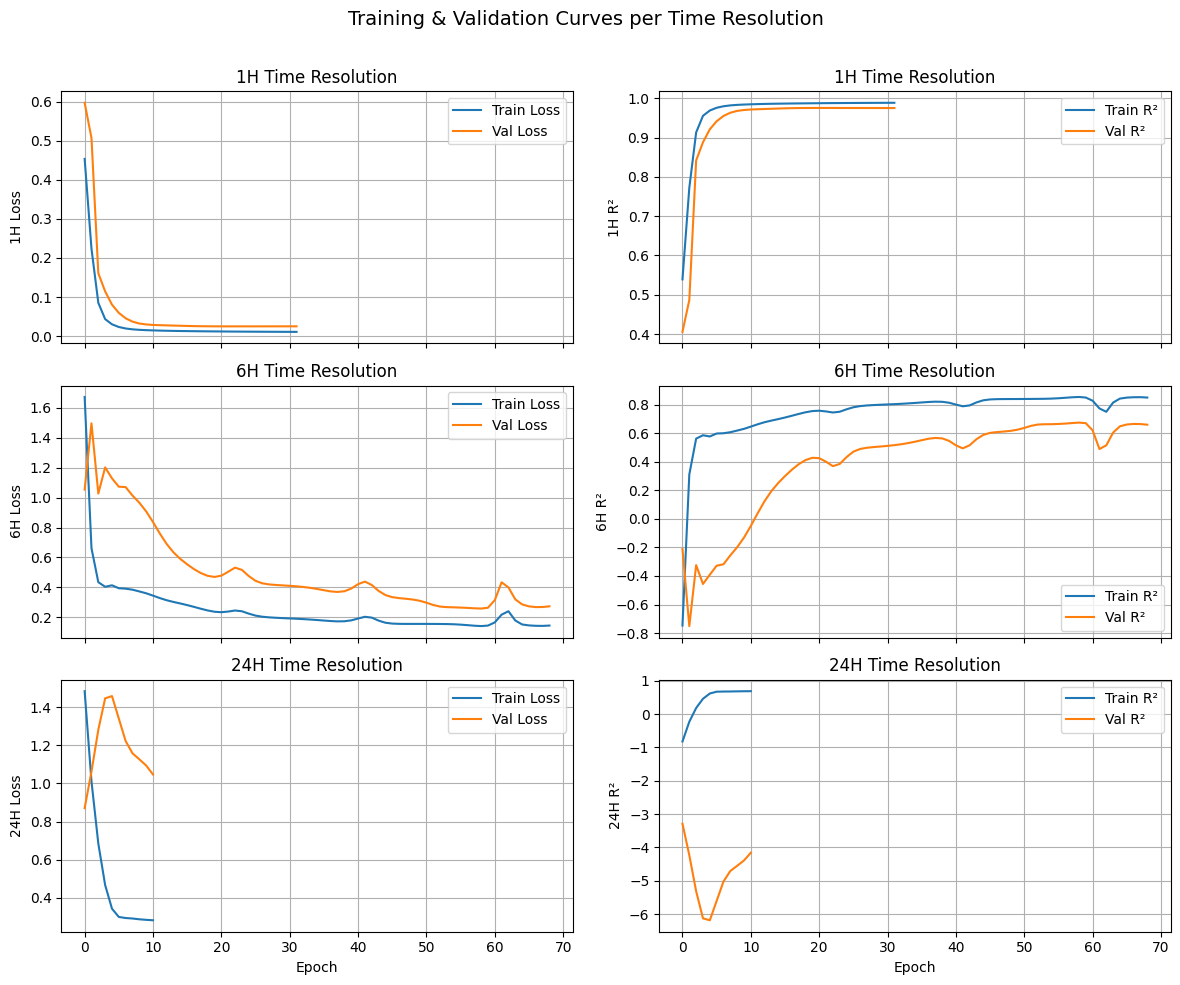

In [ ]:
# plot all learning curves
plot_learning_curves_all([mod_enc1h_history, mod_enc6h_history, mod_enc24h_history], ["1H", "6H", "24H"])

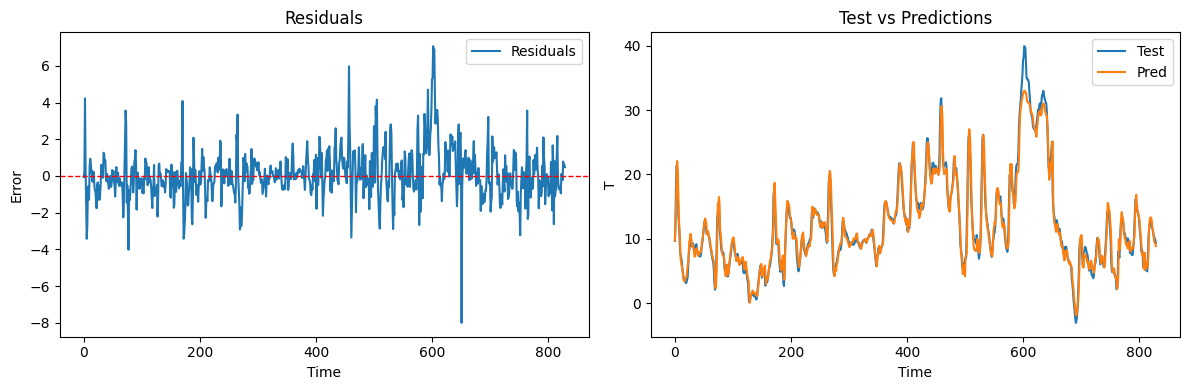


1H series (1 steps-ahead forecasts)
1H Modular Transformer-Encoder Training Time: 30.4607
1H Modular Transformer-Encoder: MAE=0.91, MSE=1.32, MAPE=11.56


In [ ]:
# 1H 1-step ahead preds
mod_enc1h_preds_norm, mod_enc1h_trues_norm, _, _ = predict_nn_mod(mod_enc1h_history["model"], hour_test_loader)

# denormalize, plot and evaluate
mod_enc1h_preds = denormalize(mod_enc1h_preds_norm, hour_mean, hour_std)
mod_enc1h_trues = denormalize(mod_enc1h_trues_norm, hour_mean, hour_std)
plot_residuals_preds(mod_enc1h_trues, mod_enc1h_preds, "1H")
mod_enc1h_mae, mod_enc1h_rmse, mod_enc1h_mape = evaluate_model(mod_enc1h_trues, mod_enc1h_preds)

print("\n1H series (1 steps-ahead forecasts)")
print(f"1H Modular Transformer-Encoder Training Time: {mod_enc1h_history['total_training_time']}")
print(f"1H Modular Transformer-Encoder: MAE={mod_enc1h_mae}, MSE={mod_enc1h_rmse}, MAPE={mod_enc1h_mape}")

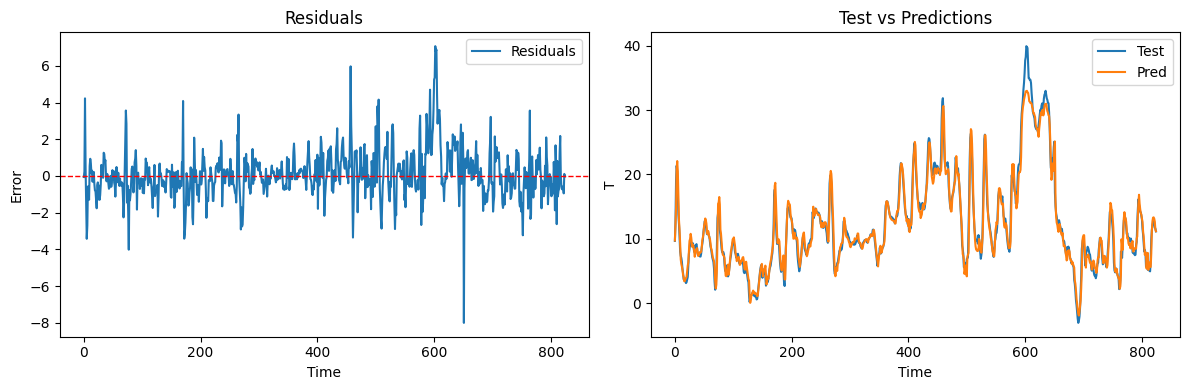


1H series (6 steps-ahead forecasts)
1H Modular Transformer-Encoder: MAE=0.91, MSE=1.32, MAPE=11.60


In [ ]:
# 1H 6-step ahead preds (we use test dataloader whose targets are the next 6 values per sample)
mod_enc16h_preds_norm, mod_enc16h_trues_norm, _, _ = predict_nn_mod(mod_enc1h_history["model"], hour6_test_loader)

# denormalize, plot and evaluate
mod_enc16h_preds = denormalize(mod_enc16h_preds_norm, hour_mean, hour_std)
mod_enc16h_trues = denormalize(mod_enc16h_trues_norm, hour_mean, hour_std)
plot_residuals_preds(mod_enc16h_trues, mod_enc16h_preds, "1H")
mod_enc16h_mae, mod_enc16h_rmse, mod_enc16h_mape = evaluate_model(mod_enc16h_trues, mod_enc16h_preds)

print("\n1H series (6 steps-ahead forecasts)")
print(f"1H Modular Transformer-Encoder: MAE={mod_enc16h_mae}, MSE={mod_enc16h_rmse}, MAPE={mod_enc16h_mape}")

In [ ]:
# see some examples of preds with its corresponding true values
print(mod_enc1h_preds[0], mod_enc1h_trues[0])
print(mod_enc16h_preds[5], mod_enc16h_trues[5])

9.724978908210417 9.66671089251817
20.471288546696456 17.045765889441146


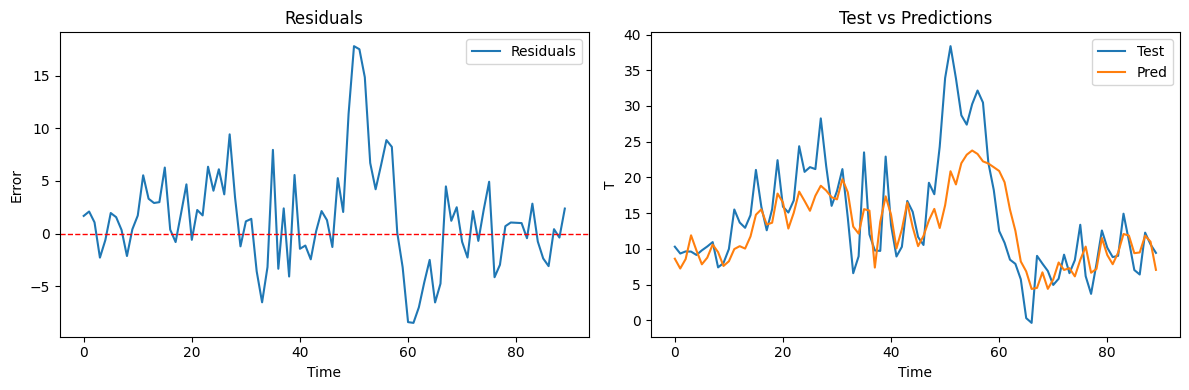


6H series (1 steps-ahead forecasts)
6H Modular Transformer-Encoder Training Time: 10.7149
6H Modular Transformer-Encoder: MAE=3.63, MSE=5.02, MAPE=63.38


In [ ]:
# 6H 1-step ahead preds
mod_enc6h_preds_norm, mod_enc6h_trues_norm, _, _ = predict_nn_mod(mod_enc6h_history["model"], six_test_loader)

# denormalize, plot and evaluate
mod_enc6h_preds = denormalize(mod_enc6h_preds_norm, six_mean, six_std)
mod_enc6h_trues = denormalize(mod_enc6h_trues_norm, six_mean, six_std)
plot_residuals_preds(mod_enc6h_trues, mod_enc6h_preds, "6H")
mod_enc6h_mae, mod_enc6h_rmse, mod_enc6h_mape = evaluate_model(mod_enc6h_trues, mod_enc6h_preds)

print("\n6H series (1 steps-ahead forecasts)")
print(f"6H Modular Transformer-Encoder Training Time: {mod_enc6h_history['total_training_time']}")
print(f"6H Modular Transformer-Encoder: MAE={mod_enc6h_mae}, MSE={mod_enc6h_rmse}, MAPE={mod_enc6h_mape}")

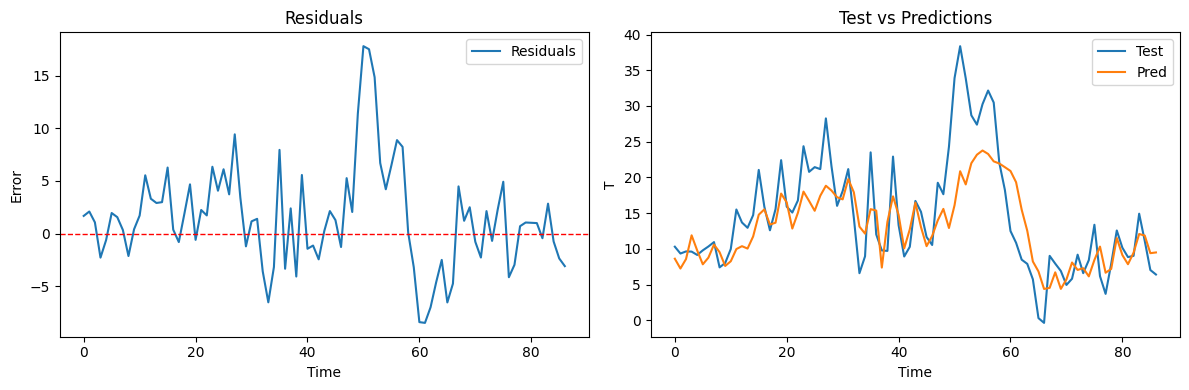


6H series (4 steps-ahead forecasts)
6H Modular Transformer-Encoder: MAE=3.72, MSE=5.10, MAPE=65.19


In [ ]:
# 6H 4-step ahead preds (we use test dataloader whose targets are the next 4 values per sample)
mod_enc64h_preds_norm, mod_enc6h4_trues_norm, _, _ = predict_nn_mod(mod_enc6h_history["model"], six4_test_loader)

# denormalize, plot and evaluate
mod_enc64h_preds = denormalize(mod_enc64h_preds_norm, six_mean, six_std)
mod_enc64h_trues = denormalize(mod_enc6h4_trues_norm, six_mean, six_std)
plot_residuals_preds(mod_enc64h_trues, mod_enc64h_preds, "6H")
mod_enc64h_mae, mod_enc64h_rmse, mod_enc64h_mape = evaluate_model(mod_enc64h_trues, mod_enc64h_preds)

print("\n6H series (4 steps-ahead forecasts)")
print(f"6H Modular Transformer-Encoder: MAE={mod_enc64h_mae}, MSE={mod_enc64h_rmse}, MAPE={mod_enc64h_mape}")

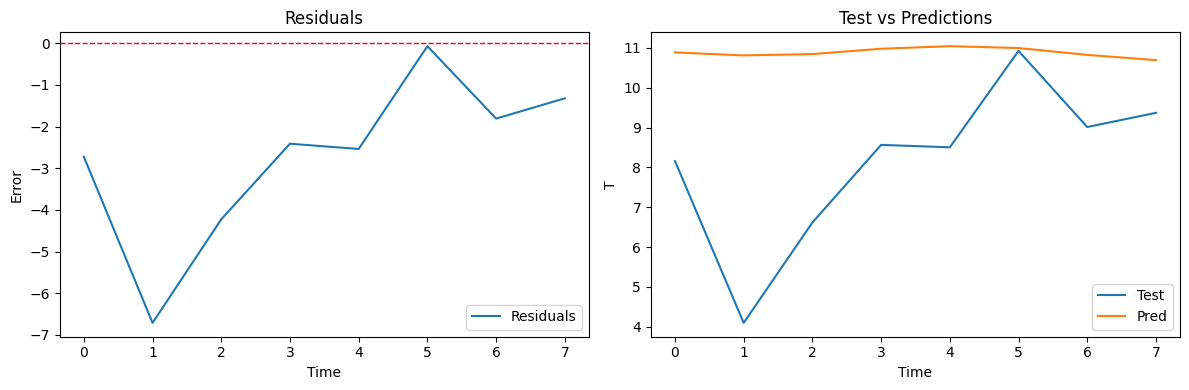


24H series (1 steps-ahead forecasts)
24H Modular Transformer-Encoder Training Time: 0.4257
24H Modular Transformer-Encoder: MAE=2.73, MSE=3.31, MAPE=44.24


In [ ]:
# 24H 1-step ahead preds
mod_enc_24h_preds_norm, mod_enc24h_trues_norm, _, _ = predict_nn_mod(mod_enc24h_history["model"], day_test_loader)

# denormalize, plot and evaluate
mod_enc24h_preds = denormalize(mod_enc_24h_preds_norm, day_mean, day_std)
mod_enc24h_trues = denormalize(mod_enc24h_trues_norm, day_mean, day_std)
plot_residuals_preds(mod_enc24h_trues, mod_enc24h_preds, "24H")
mod_enc24h_mae, mod_enc24h_rmse, mod_enc24h_mape = evaluate_model(mod_enc24h_trues, mod_enc24h_preds)

print("\n24H series (1 steps-ahead forecasts)")
print(f"24H Modular Transformer-Encoder Training Time: {mod_enc24h_history['total_training_time']}")
print(f"24H Modular Transformer-Encoder: MAE={mod_enc24h_mae}, MSE={mod_enc24h_rmse}, MAPE={mod_enc24h_mape}")

In [ ]:
enc_results += [
    ("Modular Transformer-Encoder", "1-hour", "t+1", "T_mean", "Univariate", mod_enc1h_mae, mod_enc1h_rmse, mod_enc1h_mape, mod_enc1h_history['total_training_time'], mod_enc1h_history['total_params']),
    ("Modular Transformer-Encoder", "1-hour", "t+6", "T_mean", "Univariate", mod_enc16h_mae, mod_enc16h_rmse, mod_enc16h_mape, mod_enc1h_history['total_training_time'], mod_enc1h_history['total_params']),
    ("Modular Transformer-Encoder", "6-hour", "t+1", "T_mean", "Univariate", mod_enc6h_mae, mod_enc6h_rmse, mod_enc6h_mape, mod_enc6h_history['total_training_time'], mod_enc6h_history['total_params']),
    ("Modular Transformer-Encoder", "6-hour", "t+4", "T_mean", "Univariate", mod_enc64h_mae, mod_enc64h_rmse, mod_enc64h_mape, mod_enc6h_history['total_training_time'], mod_enc6h_history['total_params']),
    ("Modular Transformer-Encoder", "24-hour", "t+1", "T_mean", "Univariate", mod_enc24h_mae, mod_enc24h_rmse, mod_enc24h_mape, mod_enc24h_history['total_training_time'], mod_enc24h_history['total_params'])
]

In [ ]:
# print results
print(tabulate(enc_results, headers=columns, tablefmt="github", floatfmt=".2f"))

| Model                       | Resolution   | Horizon   | Target Variable   | Input Type   |   MAE |   RMSE |   MAPE (%) |   Fit Time |   # Params |
|-----------------------------|--------------|-----------|-------------------|--------------|-------|--------|------------|------------|------------|
| Custom Transformer-Encoder  | 1-hour       | t+1       | T_mean            | Univariate   |  0.92 |   1.31 |      10.79 |     112.74 |       2001 |
| Custom Transformer-Encoder  | 1-hour       | t+6       | T_mean            | Univariate   |  0.92 |   1.32 |      10.82 |     112.74 |       2001 |
| Custom Transformer-Encoder  | 6-hour       | t+1       | T_mean            | Univariate   |  3.57 |   5.06 |      88.13 |       9.62 |       2001 |
| Custom Transformer-Encoder  | 6-hour       | t+4       | T_mean            | Univariate   |  3.67 |   5.15 |      91.02 |       9.62 |       2001 |
| Custom Transformer-Encoder  | 24-hour      | t+1       | T_mean            | Univariate   |  2.64 

## Results

In [ ]:
# combine and print all the above results
att_enc_results = att_results + enc_results
print(tabulate(att_enc_results, headers=columns, tablefmt="github", floatfmt=".2f"))

| Model                       | Resolution   | Horizon   | Target Variable   | Input Type   |   MAE |   RMSE |   MAPE (%) |   Fit Time |   # Params |
|-----------------------------|--------------|-----------|-------------------|--------------|-------|--------|------------|------------|------------|
| Custom Attention            | 1-hour       | t+1       | T_mean            | Univariate   |  3.46 |   4.78 |      55.44 |      68.70 |        817 |
| Custom Attention            | 1-hour       | t+6       | T_mean            | Univariate   |  4.00 |   5.58 |      64.43 |      68.70 |        817 |
| Custom Attention            | 6-hour       | t+1       | T_mean            | Univariate   |  5.23 |   6.58 |      84.66 |      26.24 |        945 |
| Custom Attention            | 6-hour       | t+4       | T_mean            | Univariate   |  6.55 |   8.05 |     144.01 |      26.24 |        945 |
| Custom Attention            | 24-hour      | t+1       | T_mean            | Univariate   |  4.78 

**Key Takeaways**


*   **Model size (# Params):** Modular versions consistently use more parameters than their custom counterparts (e.g. Modular Transformer-Encoder ~2273 vs. Custom ~2001), which is expected since the modular implementations include extra layers/components for stability and flexibility.

*   **Training time vs parameters:** Fit times generally increase with parameter count (e.g. Transformer-Encoders > Attention), but not always linearly as some modular models show faster training despite higher parameter counts, likely due to PyTorch optimizations.

*   **Performance (MAE/RMSE/MAPE):** Modular versions outperform custom ones almost across the board, showing lower errors and better generalization. This suggests the built-in modules are more robust and benefit from battle-tested implementations.

*   **Forecast horizon effect:** Predicting one step ahead (t+1) is consistently easier and yields much lower errors than multi-step horizons (t+4, t+6). As expected, error grows with longer horizons due to compounding uncertainty.

*   **Resolution effect:** The 1-hour resolution models achieve the lowest errors, while longer resolutions (6H, 24H) are harder to predict accurately. Modular Transformers maintain reasonable accuracy even at 24H.

*   **Other observation:** Training time for the 24-hour resolution models is surprisingly small compared to 1-hour/6-hour, possibly because of fewer training samples after resampling.

In [ ]:
# save and download all_results
att_enc_results = pd.DataFrame(att_enc_results, columns=columns)
att_enc_results.to_csv("att_enc_results.csv", index=False)
files.download("att_enc_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Future Work and References

**Future Work**

In this notebook, we implemented both from-scratch and modular versions of self-attention mechanisms and Transformer-encoder models. While these implementations already demonstrate their capabilities across different horizons and resolutions, there remains significant potential to further improve accuracy, robustness, and efficiency. In future work, we could explore:

*   Parameter tuning on window_size, horizon, resampling resolution (1H/6H/24H), train/val/test splits, normalization strategy, and add more features (multivariate) like humidity, solar radiation, etc.

*   Hyperparameter tuning: learning rate & schedulers, epochs, optimizer choice (Adam, AdamW, SGD+momentum, etc.), weight_decay, hidden_size, num_layers, dropout, batch_size, embedding dimension, and early-stopping patience.

*   Exploring attention variants: experiment with masked attention for causal forecasting, or cross-attention to integrate external signals (e.g. exogenous variables or other weather stations).

*   Trying pre-trained time-series models to improve generalization.


**References**

[1]: [Understanding and Coding the Self-Attention Mechanism of Large Language Models From Scratch](https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html?utm_source=chatgpt.com)

[2]: [Coding Attention Mechanisms](https://press.ocademy.cc/llm/basic/attention.html), [Self-Attention Explained with Code](https://towardsdatascience.com/contextual-transformer-embeddings-using-self-attention-explained-with-diagrams-and-python-code-d7a9f0f4d94e/), [Implementing Self-Attention from Scratch in PyTorch](https://mohdfaraaz.medium.com/implementing-self-attention-from-scratch-in-pytorch-776ef7b8f13e)

[3]: [Creating a Transformer From Scratch
Part One: The Attention Mechanism](https://benjaminwarner.dev/2023/07/01/attention-mechanism?utm_source=chatgpt.com)

[4]: [A Gentle Introduction to Positional Encoding in Transformer Models](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/)

[5]: [Building a Transformer from Scratch: A Step-by-Step Guide](https://medium.com/%40sayedebad.777/building-a-transformer-from-scratch-a-step-by-step-guide-a3df0aeb7c9a)

[6]: [Build your own Transformer from scratch using Pytorch](https://medium.com/data-science/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb)